# Librerías

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)#Prueba evaluación y entrenamiento un solo individuo. 
#Vectores completos
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random

In [2]:
import seaborn as sns

# Databases

In [3]:
#Reading all the cvs
#Nss learning
nsl_training=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Tra.csv')
#Nsl testing
nsl_testing=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Test.csv')

# Labels

In [4]:
#NSL TESTING LABELS

#Index binary (2 clases)
L_nsl_testing_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_testing_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_testing_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_testing_indextipeofattack.csv")


#nsl TRAINING LABELS
# 2 clases
L_nsl_training_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_training_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_training_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_training_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_training_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_training_indextipeofattack.csv")

# Conversión de Pandas->Numpy (array) not Matrix

In [5]:
nsl_training=nsl_training.as_matrix(columns=None)
nsl_testing=nsl_testing.as_matrix(columns=None)

# Lectura del modelo

In [6]:
from sklearn.ensemble import RandomForestClassifier

modelo=RandomForestClassifier(criterion='entropy',n_jobs=2, 
                              bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, 
                              min_samples_split=100, n_estimators=8)


# Creacion de las funciones a utilizar

# funcion muta vector binario corregida

In [7]:
def muta_vector_binario(dimensiones_temporales,M=20):
    """Dimensiones temporales: vector binario que contiene las dimensiones actuales de la ultima
        iteración probada.
        M=cantidad total de dimensiones a mutar. Si no se otorga un número
        M es igual a la máxima cantidad de dimensiones en NSL-KDD"""
    
    print("Valor de M (dimensiones a mutar): %s" %M)
    vector_mutado=np.array(dimensiones_temporales)
    #Genera números aleatorios entre 0 y M
    #Dichos numeros aleatorios seran los indices a mutar de (vector_mutado)
    indice_general=list(range(0,40))
    indice=sorted(random.sample(indice_general,M))
    
   
    #Aplica la operación negación binaria a los valores del indice
    for numero_indice in indice:
        if vector_mutado[numero_indice]==0:
            vector_mutado[numero_indice]=1
        else:
            vector_mutado[numero_indice]=0
    #regresa el vector mutado
    print("indice de vectores a mutar: ")
    print(indice)
    print("Solución actual:")
    print(dimensiones_temporales)
    print("Solución mutada:")
    print(vector_mutado)
    print("\n")
    return vector_mutado
    

In [8]:
def obtencion_parametros_binarios(vector_actual, M=40):
    """M=máximo número de dimensiones a mutar
    vector_actual= vector binario, relacionado con la ultima iteracion
    puede o no ser el mejor.
    Regresa los zeros y unos actuales,
    el ultimo vector binario,
    los dataset filtrados"""

    
    #Muta el ultimo vector
    dimensiones_temporales=muta_vector_binario(vector_actual,M)

    #se filtra la base de datos con las dimensiones de dimensiones mejor
    #SE hacen cero las dimensiones a omitir
    #dimensiones_temporales contiene la mejor iteración, entonces es la dimensión activa
    training=nsl_training*dimensiones_temporales
    testing=nsl_testing*dimensiones_temporales

    #Se buscan esos ceros en el indice (dimensiones suspendidas)
    zeros=np.where(dimensiones_temporales == 0)

    #se obtienen los indices del los unos (dimensiones activas)
    unos=np.where(dimensiones_temporales==1)

    #se eliminan esas dimensiones
    training=np.delete(training,zeros,axis=1)
    testing=np.delete(testing,zeros,axis=1)

    
    return [dimensiones_temporales,zeros,unos,training,testing]

# Funcion para calcular M dependiendo de las iteraciones

In [9]:
def M_dimensiones_a_mutar(Perror,i_actual,i_max,M_Max=40):
    iteraciones=1-(i_actual/i_max)
    M=M_Max*np.amin([iteraciones,Perror])
    M=np.array(np.round_(M))
    return M

In [10]:
def M_dimensiones_a_mutar_2(i_actual,i_max,M_Max=40):
    iteraciones=1-(i_actual/i_max)
    M=M_Max*iteraciones
    M=np.array(np.round_(M))
    return M

# Declaración del modelo

In [11]:
from sklearn.ensemble import RandomForestClassifier

modelo=RandomForestClassifier(criterion='entropy',n_jobs=2, 
                              bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, 
                              min_samples_split=100, n_estimators=8)


# Función de rendimiento

In [12]:
def funcion_rendimiento(Perror_actual,unos,N=40,alfa=.3):
    cardinalidad=np.array(unos).shape[1]
    rendimiento=alfa*Perror_actual+(1-alfa)*(cardinalidad/N)
    return rendimiento

# Inicio del algoritmo RMHC

# DOS CLASES

In [13]:
#
resultados_score=[]
resultados_cantidad_dimensiones=[]
resultados_rendimiento=[]
resultados_dimensiones_activas=[]
resultados_indices_dimensiones_activas=[]

#while
iteracion_general=0
start_time = time.time()
while iteracion_general<10:
    i=0
    M=38
    iteraciones_maximas=300
    #la declaracion tiene que ser 40! cómo puede tener menos dimensinoes???!!!
    mejor_solucion=np.random.randint(2, size=40)
    #almacena los score de todas las iteraciones
    registro_score_iteracion=[]
    #almacena la probabilidad de error de todas las iteraciones
    registro_perror_iteracion=[]
    #almacena el vector binario de todas las iteraciones
    registro_dimensiones_iteracion=[]
    #registro de la probabilidad de error de los valores aceptados
    registro_perror_valores_aceptados=[]
    #almacena unicamente el score de los vectores binarios aceptados
    registro_score_valores_aceptados=[]
    #almacena el vector binario de los valores aceptados (dimensiones_activas)
    #es un sinonimo de la mejor solucion del espacio de búsqueda
    registro_dimensiones_activas_valores_aceptados=[]
    #registro de las dimensiones activas por iteracion
    registro_dimensiones_activas_iteracion=[]
    #registro de la cantidad de dimensiones activas por iteracion
    registro_cantidad_dimensiones_activas_iteracion=[]
    #registro cantidad de dimensiones activas de los valores aceptados
    registro_cantidad_dimensiones_activas_aceptados=[]
    #registro indices de las dimensiones activas
    registro_indices_dimensiones_activas=[]

    #registro del rendimiento por iteracion
    registro_rendimiento_iteracion=[]
    #registro del rendimiento de los valore aceptados
    registro_rendimiento_aceptados=[]



    print("solucion_inicial")
    print(mejor_solucion)
    print("\n")


    #evaluacion de los primeros parametros para la PRIMER solucion
    #la cual se considera la mejor
    mejor_solucion=np.random.randint(2, size=40)


    #dimensiones temporales se omite porque YA genera el siguiente vector.
    [dimensiones_temporales,zeros,unos,training,testing]=obtencion_parametros_binarios(mejor_solucion,M)

    #craeción del modelo para el caso de DOS CLASES
    modelo.fit(training,L_nsl_training_indexbinary.values.ravel())
    predicciones=modelo.predict(testing)
    mejor_score=accuracy_score(L_nsl_testing_indexbinary,predicciones)
    mejor_perror=1-mejor_score
    mejor_rendimiento=funcion_rendimiento(mejor_perror,unos,N=40,alfa=.3)



    registro_score_valores_aceptados.append(mejor_score)
    registro_perror_valores_aceptados.append(mejor_perror)
    registro_dimensiones_activas_valores_aceptados.append(mejor_solucion)
    registro_cantidad_dimensiones_activas_aceptados.append(np.array(unos).shape[1])
    registro_rendimiento_aceptados.append(mejor_rendimiento)
    registro_indices_dimensiones_activas.append(unos)

    while (i<iteraciones_maximas):
        print("\n\n Iteracion: %s \n\n" %(i+1))

        #desde el inicio genera el siguiente vector binario partiendo que el mejor fue el primero generado.
        #dimensinoes temporales es el vector binario que va mutando con cada iteración
        [dimensiones_temporales,zeros,unos,training,testing]=obtencion_parametros_binarios(dimensiones_temporales,M)    
        #Se evaluan los resultados
        #se entrena el modelo
        modelo.fit(training,L_nsl_training_indexbinary.values.ravel())
        #se obtienen las predicciones
        predicciones=modelo.predict(testing)

        #se obtiene el accuracy score
        score_actual=accuracy_score(L_nsl_testing_indexbinary,predicciones)
        #se obtiene la probabilidad de error
        perror_actual=1-score_actual
        #se obtiene el rendimiento de dicha solucion
        rendimiento_actual=funcion_rendimiento(perror_actual,unos,N=40,alfa=.3)



        #se declara un vector que contiene todos los score de todas las iteraciones

        #Se almacenan los resultados
        registro_score_iteracion.append(score_actual)
        registro_dimensiones_iteracion.append(dimensiones_temporales)
        registro_perror_iteracion.append(perror_actual)
        registro_dimensiones_activas_iteracion.append(unos)
        registro_cantidad_dimensiones_activas_iteracion.append(np.array(unos).shape[1])
        registro_rendimiento_iteracion.append(rendimiento_actual)


        #aqui entra el If
        if rendimiento_actual < mejor_rendimiento:
            #se actualiza la mejor solucion del espacio de búsqueda
            mejor_solucion=np.array(dimensiones_temporales)
            print("\n Se encontró una mejor solución \n")
            print("Score mejor anterior: %s" %mejor_score)
            mejor_score=score_actual
            print("Score mejor actual: %s" %mejor_score)
            print("Rendimiento anterior: %s" %mejor_rendimiento)
            print("Rendimiento actual: %s" %rendimiento_actual)
            mejor_rendimiento=np.array(rendimiento_actual)

            print("Cantidad de Dimensiones activas anteriores: %s" %(
                registro_cantidad_dimensiones_activas_aceptados[-1]))
            #np.array(registro_dimensiones_activas_iteracion[-1]).shape[1]
            print("Cantidad de Dimensiones activas actuales: %s" %np.array(unos).shape[1])




            #impresion de parametros
            registro_score_valores_aceptados.append(mejor_score)
            registro_perror_valores_aceptados.append(perror_actual)
            registro_dimensiones_activas_valores_aceptados.append(dimensiones_temporales)
            registro_rendimiento_aceptados.append(rendimiento_actual)
            registro_cantidad_dimensiones_activas_aceptados.append(np.array(unos).shape[1])
            registro_indices_dimensiones_activas.append(unos)


        #Se imprimen los resultados
        print("Indice de las Dimensiones activas: ")
        print(unos)
        print("Total de dimensiones activas: %s" % np.array(unos).shape[1])
        print("Porcentaje de exactitud: %s (accuracy score)" %accuracy_score(L_nsl_testing_indexbinary,predicciones))
        print("Probabilidad de error (Perror): %s" % (1-accuracy_score(L_nsl_testing_indexbinary,predicciones)))
        print("Rendimiento (RE): %s" %rendimiento_actual)





        #M se calcula al final

        #M=M_dimensiones_a_mutar_2(i,iteraciones_maximas,M_Max=40)

        M=M_dimensiones_a_mutar(perror_actual,i,iteraciones_maximas,M_Max=40)


        #M debe ser entero o da un error al elegir el sampleo aleatorio en la seleccion de dimensiones
        #problema porque M es flotante
        M=int(M)


        i=i+1
    
    resultados_score.append(registro_score_valores_aceptados)
    resultados_cantidad_dimensiones.append(registro_cantidad_dimensiones_activas_aceptados)
    resultados_rendimiento.append(registro_rendimiento_aceptados)
    resultados_dimensiones_activas.append(registro_dimensiones_activas_valores_aceptados)
    resultados_indices_dimensiones_activas.append(registro_indices_dimensiones_activas)
    
    iteracion_general=iteracion_general+1
t_entrenamiento_f_o=(time.time() - start_time)


print("\n Tiempo de RMHC\n")
print("--- %s seconds ---" % t_entrenamiento_f_o)

solucion_inicial
[1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0
 0 0 1]


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39]
Solución actual:
[0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0
 1 1 1]
Solución mutada:
[1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0
 0 0 0]




 Iteracion: 1 


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Solución actual:
[1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0
 0 0 0]
Solución mutada:
[0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  

Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  7, 10, 14, 15, 19, 20, 21, 23, 25, 28, 30, 31, 33,
       35, 36, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.760235993435 (accuracy score)
Probabilidad de error (Perror): 0.239764006565
Rendimiento (RE): 0.43942920197


 Iteracion: 14 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 4, 15, 17, 18, 20, 21, 22, 25, 36]
Solución actual:
[1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1
 0 1 1]
Solución mutada:
[1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  6,  7, 10, 14, 17, 18, 19, 22, 23, 28, 30, 31, 33, 35,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.740096704077 (accuracy score)
Probabilidad de error (Perror): 0.259903295923
Rendimiento (RE): 0.410470988777


 Iteracion: 15 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  8,  9, 11, 14, 17, 20, 22, 25, 26, 28, 33, 35, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.765869671295 (accuracy score)
Probabilidad de error (Perror): 0.234130328705
Rendimiento (RE): 0.367739098612


 Iteracion: 28 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[6, 8, 11, 17, 22, 26, 30, 33, 38]
Solución actual:
[1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0
 0 0 1]
Solución mutada:
[1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0
 0 1 1]



 Se encontró una mejor solución 

Score mejor anterior: 0.765514793949
Score mejor actual: 0.810672936166
Rendimiento anterior: 0.315345561815
Rendimiento actual: 0.30179811915
Cantidad de Dimensiones activas anteriores: 14
Cantidad de Dimensiones activas actuales: 14
Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  6,  9, 14, 20, 25, 28, 30, 35, 38, 39]),)
Total de dimensiones

Indice de las Dimensiones activas: 
(array([ 2,  3,  7, 15, 19, 21, 22, 23, 25, 26, 27, 29, 30, 31, 36]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.776649070665 (accuracy score)
Probabilidad de error (Perror): 0.223350929335
Rendimiento (RE): 0.329505278801


 Iteracion: 41 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 8, 12, 16, 21, 23, 27, 36]
Solución actual:
[0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1
 0 0 0]
Solución mutada:
[1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7,  8, 12, 15, 16, 19, 22, 25, 26, 29, 30, 31]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.779266291088 (accuracy score)
Probabilidad de error (Perror): 0.220733708912
Rendimiento (RE): 0.346220112674


 Iteracion: 42 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 4, 13, 21, 25, 26, 28, 32, 33]
S

Indice de las Dimensiones activas: 
(array([ 5,  7,  8, 12, 13, 14, 16, 19, 20, 21, 23, 24, 27, 29, 30, 33, 35,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.717783790977 (accuracy score)
Probabilidad de error (Perror): 0.282216209023
Rendimiento (RE): 0.417164862707


 Iteracion: 55 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[2, 3, 5, 9, 10, 11, 12, 23, 24, 32, 35]
Solución actual:
[0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0
 1 1 0]
Solución mutada:
[0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  7,  8,  9, 10, 11, 13, 14, 16, 19, 20, 21, 27, 29, 30, 32,
       33, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.748879918378 (accuracy score)
Probabilidad de error (Perror): 0.251120081622
Rendimiento (RE): 0.425336024487


 Iteracion: 56 


Valor de M (dimensiones a mutar): 10
indice de 

Indice de las Dimensiones activas: 
(array([ 0,  3,  4, 10, 11, 12, 14, 16, 19, 20, 22, 23, 25, 27, 28, 30, 32,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.751186621124 (accuracy score)
Probabilidad de error (Perror): 0.248813378876
Rendimiento (RE): 0.407144013663


 Iteracion: 69 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 8, 11, 15, 16, 19, 26, 27, 38, 39]
Solución actual:
[1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0
 1 0 0]
Solución mutada:
[0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  4,  8, 10, 12, 14, 15, 20, 22, 23, 25, 26, 28, 30, 32, 35, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.761211906135 (accuracy score)
Probabilidad de error (Perror): 0.238788093865
Rendimiento (RE): 0.40413642816


 Iteracion: 70 


Valor de M (dimensiones a mutar): 10
indice de vectore

Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  7, 10, 11, 13, 15, 17, 18, 19, 24, 25, 26, 27, 28, 33,
       35, 36, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.737479483653 (accuracy score)
Probabilidad de error (Perror): 0.262520516347
Rendimiento (RE): 0.428756154904


 Iteracion: 83 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1, 6, 9, 15, 19, 21, 31, 34, 35, 36, 37]
Solución actual:
[1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1
 1 0 0]
Solución mutada:
[1 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  7,  9, 10, 11, 13, 17, 18, 21, 24, 25, 26, 27, 28, 31,
       33, 34]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.756642860311 (accuracy score)
Probabilidad de error (Perror): 0.243357139689
Rendimiento (RE): 0.405507141907


 Iteracion: 84 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  7,  9, 11, 13, 14, 15, 18, 20, 24, 26, 28, 30, 31, 32,
       33, 35, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.748613760369 (accuracy score)
Probabilidad de error (Perror): 0.251386239631
Rendimiento (RE): 0.442915871889


 Iteracion: 97 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 6, 7, 10, 16, 18, 25, 30, 33, 35]
Solución actual:
[0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 1 0 0]
Solución mutada:
[0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  9, 10, 11, 13, 14, 15, 16, 20, 24, 25, 26, 28, 31, 32,
       36, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.753803841547 (accuracy score)
Probabilidad de error (Perror): 0.246196158453
Rendimiento (RE): 0.406358847536


 Iteracion: 98 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  9, 11, 12, 13, 14, 15, 18, 19, 20, 21, 24, 25, 27, 28,
       30, 31, 32, 33, 34, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.760679590117 (accuracy score)
Probabilidad de error (Perror): 0.239320409883
Rendimiento (RE): 0.474296122965


 Iteracion: 111 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 5, 9, 15, 23, 24, 30, 35, 36, 38]
Solución actual:
[1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0
 0 1 0]
Solución mutada:
[1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5, 11, 12, 13, 14, 18, 19, 20, 21, 23, 25, 27, 28,
       31, 32, 33, 34, 35, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.781218116488 (accuracy score)
Probabilidad de error (Perror): 0.218781883512
Rendimiento (RE): 0.468134565053


 Iteracion: 112 


Valor de M (dimensio

Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7,  8,  9, 11, 13, 14, 17, 18, 20, 23, 24, 26, 27, 29,
       30, 34, 35, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.77310029721 (accuracy score)
Probabilidad de error (Perror): 0.22689970279
Rendimiento (RE): 0.453069910837


 Iteracion: 124 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 7, 10, 11, 19, 20, 23, 29, 38]
Solución actual:
[0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0
 0 1 1]
Solución mutada:
[0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  5,  8,  9, 10, 13, 14, 17, 18, 19, 24, 26, 27, 30, 34,
       35, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.774342367919 (accuracy score)
Probabilidad de error (Perror): 0.225657632081
Rendimiento (RE): 0.400197289624


 Iteracion: 125 


Valor de M (dimensiones a mutar): 9
indice de 

Indice de las Dimensiones activas: 
(array([ 4,  5,  6,  7, 10, 11, 12, 13, 16, 19, 20, 22, 24, 26, 27, 31, 33,
       35, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.766313267977 (accuracy score)
Probabilidad de error (Perror): 0.233686732023
Rendimiento (RE): 0.402606019607


 Iteracion: 137 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 2, 3, 10, 19, 23, 28, 33, 39]
Solución actual:
[0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 1 0]
Solución mutada:
[0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 16, 20, 22, 23, 24, 26, 27,
       28, 31, 35, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.778645255733 (accuracy score)
Probabilidad de error (Perror): 0.221354744267
Rendimiento (RE): 0.45140642328


 Iteracion: 138 


Valor de M (dimensiones a mutar): 9
indice de 

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6,  7,  8, 12, 15, 19, 20, 22, 23, 25, 26, 27, 28, 31,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.787472829703 (accuracy score)
Probabilidad de error (Perror): 0.212527170297
Rendimiento (RE): 0.396258151089


 Iteracion: 151 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 5, 14, 16, 17, 20, 27, 29, 34]
Solución actual:
[1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0
 0 1 1]
Solución mutada:
[1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  6,  7,  8, 12, 14, 15, 16, 17, 19, 22, 23, 25,
       26, 28, 29, 31, 34, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.767156101672 (accuracy score)
Probabilidad de error (Perror): 0.232843898328
Rendimiento (RE): 0.489853169498


 Iteracion: 152 


Valor de M (dimensiones a mutar): 9


Indice de las Dimensiones activas: 
(array([ 1,  4,  6,  7, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25,
       26, 27, 30, 31, 36, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.777669343033 (accuracy score)
Probabilidad de error (Perror): 0.222330656967
Rendimiento (RE): 0.48669919709


 Iteracion: 164 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 6, 12, 17, 21, 25, 29, 38, 39]
Solución actual:
[0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1
 1 1 0]
Solución mutada:
[0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  7, 10, 11, 14, 15, 16, 18, 19, 20, 22, 26, 27, 29, 30,
       31, 36, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.78068580047 (accuracy score)
Probabilidad de error (Perror): 0.21931419953
Rendimiento (RE): 0.433294259859


 Iteracion: 165 


Valor de M (dimensiones a mutar

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  8, 10, 11, 15, 18, 20, 22, 24, 26, 27, 28, 30, 31,
       32, 34, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.741427494122 (accuracy score)
Probabilidad de error (Perror): 0.258572505878
Rendimiento (RE): 0.462571751763


 Iteracion: 178 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 5, 6, 9, 17, 18, 19, 23, 38, 39]
Solución actual:
[1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1
 1 0 0]
Solución mutada:
[1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  6,  8,  9, 10, 11, 15, 17, 19, 20, 22, 23, 24, 26,
       27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 28
Porcentaje de exactitud: 0.772479261855 (accuracy score)
Probabilidad de error (Perror): 0.227520738145
Rendimiento (RE): 0.558256221443


 Iteracion: 179 


Valor

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  6,  7,  9, 10, 11, 14, 17, 19, 20, 22, 24, 25,
       26, 29, 30, 33, 36, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.747504768664 (accuracy score)
Probabilidad de error (Perror): 0.252495231336
Rendimiento (RE): 0.495748569401


 Iteracion: 191 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 6, 8, 9, 19, 23, 24, 26, 28, 31]
Solución actual:
[1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1
 0 1 1]
Solución mutada:
[1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  7,  8, 10, 11, 14, 17, 20, 22, 23, 25, 28, 29, 30,
       31, 33, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.774919043606 (accuracy score)
Probabilidad de error (Perror): 0.225080956394
Rendimiento (RE): 0.452524286918


 Iteracion: 192 


Valor de M (dimension

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  7, 11, 12, 14, 16, 18, 22, 23, 24, 25, 27, 35, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.762542696181 (accuracy score)
Probabilidad de error (Perror): 0.237457303819
Rendimiento (RE): 0.368737191146


 Iteracion: 204 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[15, 17, 18, 19, 25, 27, 28, 30, 32]
Solución actual:
[1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0
 0 1 1]
Solución mutada:
[1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  7, 11, 12, 14, 15, 16, 17, 19, 22, 23, 24, 28, 30, 32,
       35, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.765115556936 (accuracy score)
Probabilidad de error (Perror): 0.234884443064
Rendimiento (RE): 0.420465332919


 Iteracion: 205 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  6,  7,  8, 10, 11, 12, 13, 16, 17, 21, 23, 24, 26, 28,
       30, 32, 34, 35, 37, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.778867054074 (accuracy score)
Probabilidad de error (Perror): 0.221132945926
Rendimiento (RE): 0.468839883778


 Iteracion: 217 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 5, 8, 15, 24, 26, 32, 33, 34]
Solución actual:
[0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 1 0 1]
Solución mutada:
[0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  6,  7, 10, 11, 12, 13, 15, 16, 17, 21, 23, 28, 30, 33,
       35, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.761744222153 (accuracy score)
Probabilidad de error (Perror): 0.238255777847
Rendimiento (RE): 0.421476733354


 Iteracion: 218 


Valor de M (dimensiones a mutar): 10


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  7,  8, 11, 14, 15, 18, 20, 26, 29, 30, 31, 32, 34,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.77163642816 (accuracy score)
Probabilidad de error (Perror): 0.22836357184
Rendimiento (RE): 0.401009071552


 Iteracion: 230 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 5, 17, 21, 22, 27, 29, 33, 39]
Solución actual:
[0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0
 1 0 0]
Solución mutada:
[0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  7,  8, 11, 14, 15, 17, 18, 20, 21, 22, 26, 27, 30,
       31, 32, 33, 34, 35, 37, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.778379097724 (accuracy score)
Probabilidad de error (Perror): 0.221620902276
Rendimiento (RE): 0.486486270683


 Iteracion: 231 


Valor de M (dimensiones a mutar): 9
in

Indice de las Dimensiones activas: 
(array([ 0,  4,  7,  8, 10, 15, 16, 18, 19, 21, 24, 28, 32, 34, 35, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.745331144923 (accuracy score)
Probabilidad de error (Perror): 0.254668855077
Rendimiento (RE): 0.356400656523


 Iteracion: 244 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[3, 5, 10, 18, 19, 23, 28, 30]
Solución actual:
[1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0
 0 0 1]
Solución mutada:
[1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  7,  8, 15, 16, 21, 23, 24, 30, 32, 34, 35, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.755977465289 (accuracy score)
Probabilidad de error (Perror): 0.244022534711
Rendimiento (RE): 0.353206760413


 Iteracion: 245 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[6, 9, 16, 17, 18, 23, 25, 32]
So

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  6,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22,
       23, 28, 32, 35, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.73854411569 (accuracy score)
Probabilidad de error (Perror): 0.26145588431
Rendimiento (RE): 0.463436765293


 Iteracion: 258 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[11, 14, 20, 21, 22, 29]
Solución actual:
[1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0
 1 0 0]
Solución mutada:
[1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23,
       28, 29, 32, 35, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.737612562658 (accuracy score)
Probabilidad de error (Perror): 0.262387437342
Rendimiento (RE): 0.463716231203


 Iteracion: 259 


Valor de M (dimensiones a mutar): 6
indice d

Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  8, 11, 15, 17, 18, 20, 21, 22, 23, 26, 27, 28, 31, 32,
       33, 34, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.749767111742 (accuracy score)
Probabilidad de error (Perror): 0.250232888258
Rendimiento (RE): 0.425069866477


 Iteracion: 272 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[2, 8, 11, 21]
Solución actual:
[0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 1 0]
Solución mutada:
[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  6, 15, 17, 18, 20, 22, 23, 26, 27, 28, 31, 32, 33, 34, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.738810273699 (accuracy score)
Probabilidad de error (Perror): 0.261189726301
Rendimiento (RE): 0.35835691789


 Iteracion: 273 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[9, 29, 32, 35]
Solución ac

Indice de las Dimensiones activas: 
(array([ 1,  7,  8,  9, 10, 12, 13, 14, 17, 24, 26, 27, 28, 29, 31, 32, 33,
       34, 36, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.746795013973 (accuracy score)
Probabilidad de error (Perror): 0.253204986027
Rendimiento (RE): 0.425961495808


 Iteracion: 286 


Valor de M (dimensiones a mutar): 2
indice de vectores a mutar: 
[17, 36]
Solución actual:
[0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 0 0]
Solución mutada:
[0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  7,  8,  9, 10, 12, 13, 14, 24, 26, 27, 28, 29, 31, 32, 33, 34,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.756909018321 (accuracy score)
Probabilidad de error (Perror): 0.243090981679
Rendimiento (RE): 0.387927294504


 Iteracion: 287 


Valor de M (dimensiones a mutar): 2
indice de vectores a mutar: 
[7, 24]
Solución 

Indice de las Dimensiones activas: 
(array([ 1,  4,  9, 10, 14, 19, 24, 26, 27, 28, 29, 33, 34, 36]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.753360244865 (accuracy score)
Probabilidad de error (Perror): 0.246639755135
Rendimiento (RE): 0.31899192654
solucion_inicial
[0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1
 0 1 1]


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39]
Solución actual:
[0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0
 1 0 0]
Solución mutada:
[1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0
 0 1 1]




 Iteracion: 1 


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36

Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 18, 19, 21, 22, 23, 24, 25,
       32, 33, 34, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.742669564832 (accuracy score)
Probabilidad de error (Perror): 0.257330435168
Rendimiento (RE): 0.444699130551


 Iteracion: 13 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 4, 13, 14, 18, 21, 25, 29, 34, 38]
Solución actual:
[0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0
 1 0 0]
Solución mutada:
[1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  6,  8,  9, 10, 12, 19, 22, 23, 24, 29, 32, 33, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.746928092978 (accuracy score)
Probabilidad de error (Perror): 0.253071907022
Rendimiento (RE): 0.373421572107


 Iteracion: 14 


Valor de M (dimensiones a mutar): 10
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  8,  9, 11, 12, 15, 16, 20, 23, 25, 27, 29, 31, 32,
       33, 34, 35, 36, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.741338774786 (accuracy score)
Probabilidad de error (Perror): 0.258661225214
Rendimiento (RE): 0.462598367564


 Iteracion: 26 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 3, 5, 6, 13, 16, 19, 22, 25, 34]
Solución actual:
[1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1
 0 0 1]
Solución mutada:
[1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  8,  9, 11, 12, 13, 15, 19, 20, 22, 23, 27, 29, 31,
       32, 33, 35, 36, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.746661934969 (accuracy score)
Probabilidad de error (Perror): 0.253338065031
Rendimiento (RE): 0.461001419509


 Iteracion: 27 


Valor de M (dimensiones a mutar

Indice de las Dimensiones activas: 
(array([ 1,  3,  5, 13, 14, 15, 20, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.740673379763 (accuracy score)
Probabilidad de error (Perror): 0.259326620237
Rendimiento (RE): 0.375297986071


 Iteracion: 39 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 5, 6, 10, 14, 16, 20, 25, 26, 36]
Solución actual:
[0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1
 1 1 0]
Solución mutada:
[1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  6, 10, 13, 15, 16, 25, 28, 29, 31, 32, 33, 34, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.729494743379 (accuracy score)
Probabilidad de error (Perror): 0.270505256621
Rendimiento (RE): 0.378651576986


 Iteracion: 40 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1, 4, 5, 17, 19, 

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  6,  7, 11, 12, 13, 14, 15, 19, 22, 23, 25, 27, 29, 32,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.742403406823 (accuracy score)
Probabilidad de error (Perror): 0.257596593177
Rendimiento (RE): 0.427278977953


 Iteracion: 52 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 6, 18, 23, 28, 30, 33, 34, 35, 37]
Solución actual:
[1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0
 1 1 1]
Solución mutada:
[1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  4,  7, 11, 12, 13, 14, 15, 18, 19, 22, 25, 27, 28, 29, 30, 32,
       33, 34, 35, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.737213325644 (accuracy score)
Probabilidad de error (Perror): 0.262786674356
Rendimiento (RE): 0.463836002307


 Iteracion: 53 


Valor de M (dimensiones a mutar): 11


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  6,  7,  8, 10, 11, 12, 14, 15, 20, 22, 23, 25, 26, 29,
       31, 32, 33, 34, 35, 36, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.764228363572 (accuracy score)
Probabilidad de error (Perror): 0.235771636428
Rendimiento (RE): 0.490731490928


 Iteracion: 65 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 3, 7, 9, 11, 16, 23, 35, 38]
Solución actual:
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1
 0 1 0]
Solución mutada:
[1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 12, 14, 15, 16, 20, 22, 25, 26,
       29, 31, 32, 33, 34, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.755045912257 (accuracy score)
Probabilidad de error (Perror): 0.244954087743
Rendimiento (RE): 0.475986226323


 Iteracion: 66 


Valor de M (dimensiones 

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6, 11, 13, 15, 16, 17, 21, 23, 24, 25, 28, 30, 31, 33,
       35, 36, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.771325910482 (accuracy score)
Probabilidad de error (Perror): 0.228674089518
Rendimiento (RE): 0.453602226855


 Iteracion: 79 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 3, 4, 8, 13, 15, 17, 22, 30]
Solución actual:
[1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1
 1 1 1]
Solución mutada:
[0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  8, 11, 16, 21, 22, 23, 24, 25, 28, 31, 33, 35,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.781085037484 (accuracy score)
Probabilidad de error (Perror): 0.218914962516
Rendimiento (RE): 0.433174488755


 Iteracion: 80 


Valor de M (dimensiones a mutar): 9
indi

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  7,  8, 10, 11, 14, 15, 19, 20, 22, 26, 28, 29, 33, 34,
       35, 36, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.741383134454 (accuracy score)
Probabilidad de error (Perror): 0.258616865546
Rendimiento (RE): 0.427585059664


 Iteracion: 93 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[5, 6, 7, 15, 23, 27, 28, 29, 34, 39]
Solución actual:
[1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1
 0 0 1]
Solución mutada:
[1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  8, 10, 11, 14, 19, 20, 22, 23, 26, 27, 33, 35,
       36]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.769595883423 (accuracy score)
Probabilidad de error (Perror): 0.230404116577
Rendimiento (RE): 0.384121234973


 Iteracion: 94 


Valor de M (dimensiones a mutar): 9
indice de vectores

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19, 20, 23,
       24, 25, 26, 28, 29, 30, 31, 34, 35, 38]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.787517189371 (accuracy score)
Probabilidad de error (Perror): 0.212482810629
Rendimiento (RE): 0.536244843189


 Iteracion: 107 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[1, 10, 13, 19, 21, 24, 25, 33]
Solución actual:
[1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0
 0 1 0]
Solución mutada:
[1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7,  8,  9, 11, 12, 14, 15, 20, 21, 23, 26, 28, 29,
       30, 31, 33, 34, 35, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.758993922725 (accuracy score)
Probabilidad de error (Perror): 0.241006077275
Rendimiento (RE): 0.474801823182


 Iteracion: 108 


Valor de M 

Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  6,  7,  8, 10, 11, 13, 15, 17, 18, 19, 21, 24, 26, 28,
       29, 32, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.763474249213 (accuracy score)
Probabilidad de error (Perror): 0.236525750787
Rendimiento (RE): 0.490957725236


 Iteracion: 121 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 4, 9, 12, 17, 19, 20, 26, 33]
Solución actual:
[0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1
 1 1 1]
Solución mutada:
[0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  6,  7,  8,  9, 10, 11, 12, 13, 15, 18, 20, 21, 24, 28, 29, 32,
       33, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.737257685313 (accuracy score)
Probabilidad de error (Perror): 0.262742314687
Rendimiento (RE): 0.481322694406


 Iteracion: 122 


Valor de M (dimension

Indice de las Dimensiones activas: 
(array([ 3,  4,  6,  7,  8, 10, 13, 15, 23, 25, 27, 28, 29, 31, 32, 33, 34,
       35, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.774253648583 (accuracy score)
Probabilidad de error (Perror): 0.225746351417
Rendimiento (RE): 0.400223905425


 Iteracion: 135 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 4, 11, 12, 16, 17, 22, 28, 36]
Solución actual:
[0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0
 0 0 1]
Solución mutada:
[0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 22, 23, 25, 27, 29, 31, 32,
       33, 34, 35, 36, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.721288204764 (accuracy score)
Probabilidad de error (Perror): 0.278711795236
Rendimiento (RE): 0.468613538571


 Iteracion: 136 


Valor de M (dimensiones a mutar): 11
indice 

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  7,  9, 10, 13, 14, 16, 17, 19, 20, 21, 23, 24, 25,
       27, 32, 35, 36, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.780375282793 (accuracy score)
Probabilidad de error (Perror): 0.219624717207
Rendimiento (RE): 0.450887415162


 Iteracion: 149 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 2, 4, 9, 13, 22, 29, 36, 37]
Solución actual:
[0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 1 0]
Solución mutada:
[1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  7, 10, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 29,
       32, 35, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.72554673291 (accuracy score)
Probabilidad de error (Perror): 0.27445326709
Rendimiento (RE): 0.449835980127


 Iteracion: 150 


Valor de M (dimensiones a mutar): 11
ind

Indice de las Dimensiones activas: 
(array([ 5,  6, 14, 17, 18, 20, 24, 26, 27, 29, 33, 36, 37, 39]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.69737834361 (accuracy score)
Probabilidad de error (Perror): 0.30262165639
Rendimiento (RE): 0.335786496917


 Iteracion: 162 


Valor de M (dimensiones a mutar): 12
indice de vectores a mutar: 
[1, 2, 3, 5, 7, 12, 14, 16, 17, 21, 25, 34]
Solución actual:
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1
 1 0 1]
Solución mutada:
[0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  7, 12, 16, 18, 20, 21, 24, 25, 26, 27, 29, 33, 34,
       36, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.767200461341 (accuracy score)
Probabilidad de error (Perror): 0.232799538659
Rendimiento (RE): 0.419839861598


 Iteracion: 163 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3,

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  5,  8,  9, 14, 19, 20, 22, 23, 24, 28, 29, 30, 35,
       36]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.786053320321 (accuracy score)
Probabilidad de error (Perror): 0.213946679679
Rendimiento (RE): 0.379184003904


 Iteracion: 175 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 5, 10, 25, 26, 27, 33, 35, 37]
Solución actual:
[1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1
 0 0 0]
Solución mutada:
[1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  8,  9, 10, 14, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 33, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.760990107794 (accuracy score)
Probabilidad de error (Perror): 0.239009892206
Rendimiento (RE): 0.439202967662


 Iteracion: 176 


Valor de M (dimensiones a mutar): 10
indice de vecto

Indice de las Dimensiones activas: 
(array([ 5,  6,  7,  9, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 28, 29,
       30, 31, 33, 34, 35, 36, 38, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.749722752074 (accuracy score)
Probabilidad de error (Perror): 0.250277247926
Rendimiento (RE): 0.512583174378


 Iteracion: 188 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 2, 5, 7, 12, 15, 17, 20, 27, 38]
Solución actual:
[0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1
 0 1 1]
Solución mutada:
[1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26,
       27, 28, 29, 30, 31, 33, 34, 35, 36, 39]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.749855831078 (accuracy score)
Probabilidad de error (Perror): 0.250144168922
Rendimiento (RE): 0.547543250676


 Iteracion: 189 

Indice de las Dimensiones activas: 
(array([12, 14, 16, 17, 18, 19, 22, 27, 31, 32, 33, 35, 37]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.701903029765 (accuracy score)
Probabilidad de error (Perror): 0.298096970235
Rendimiento (RE): 0.31692909107


 Iteracion: 201 


Valor de M (dimensiones a mutar): 12
indice de vectores a mutar: 
[1, 5, 6, 12, 15, 16, 20, 23, 25, 27, 35, 36]
Solución actual:
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0
 1 0 0]
Solución mutada:
[0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  5,  6, 14, 15, 17, 18, 19, 20, 22, 23, 25, 31, 32, 33, 36, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.726034689261 (accuracy score)
Probabilidad de error (Perror): 0.273965310739
Rendimiento (RE): 0.379689593222


 Iteracion: 202 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[4, 6, 13, 17, 22, 23, 31

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  7, 10, 12, 13, 15, 18, 19, 20, 21, 22, 24, 29, 32, 33,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.747238610655 (accuracy score)
Probabilidad de error (Perror): 0.252761389345
Rendimiento (RE): 0.408328416803


 Iteracion: 215 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 9, 12, 15, 19, 27, 34, 35, 37, 39]
Solución actual:
[1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 1 0 0]
Solución mutada:
[1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  7,  8,  9, 10, 13, 18, 20, 21, 22, 24, 27, 29, 32, 33,
       34, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.732333762143 (accuracy score)
Probabilidad de error (Perror): 0.267666237857
Rendimiento (RE): 0.412799871357


 Iteracion: 216 


Valor de M (dimensiones a mutar): 11
indice de vect

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7,  9, 11, 17, 18, 19, 20, 22, 24, 28, 30, 31, 32,
       33, 34, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.774386727587 (accuracy score)
Probabilidad de error (Perror): 0.225613272413
Rendimiento (RE): 0.435183981724


 Iteracion: 229 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 6, 7, 11, 13, 29, 30, 34, 36]
Solución actual:
[1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1
 1 0 0]
Solución mutada:
[0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  6,  9, 13, 17, 18, 19, 20, 22, 24, 28, 29, 31, 32, 33,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.763607328217 (accuracy score)
Probabilidad de error (Perror): 0.236392671783
Rendimiento (RE): 0.385917801535


 Iteracion: 230 


Valor de M (dimensiones a mutar): 9
indice de vectore

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  5,  7,  8, 14, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28,
       30, 31, 32, 33, 34, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.746528855964 (accuracy score)
Probabilidad de error (Perror): 0.253471144036
Rendimiento (RE): 0.478541343211


 Iteracion: 242 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[2, 5, 17, 18, 19, 22, 29, 32]
Solución actual:
[1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 0 0 0]
Solución mutada:
[1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  7,  8, 14, 16, 17, 19, 20, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 33, 34, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.747282970323 (accuracy score)
Probabilidad de error (Perror): 0.252717029677
Rendimiento (RE): 0.478315108903


 Iteracion: 243 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  7,  8, 11, 15, 16, 17, 20, 24, 25, 26, 29, 30, 31, 34,
       35, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.778423457393 (accuracy score)
Probabilidad de error (Perror): 0.221576542607
Rendimiento (RE): 0.398972962782


 Iteracion: 256 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[2, 4, 17, 26, 28, 38]
Solución actual:
[0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0
 0 1 0]
Solución mutada:
[0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7,  8, 11, 15, 16, 20, 24, 25, 28, 29, 30, 31, 34, 35]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.760191633767 (accuracy score)
Probabilidad de error (Perror): 0.239808366233
Rendimiento (RE): 0.36944250987


 Iteracion: 257 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[1, 5, 6, 8, 10, 25

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  6,  8, 14, 16, 17, 18, 21, 22, 23, 25, 26, 29, 30, 31,
       34, 35, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.758417247039 (accuracy score)
Probabilidad de error (Perror): 0.241582752961
Rendimiento (RE): 0.439974825888


 Iteracion: 270 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[13, 14, 26, 37]
Solución actual:
[1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1
 1 0 0]
Solución mutada:
[1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  6,  8, 13, 16, 17, 18, 21, 22, 23, 25, 29, 30, 31, 34,
       35, 36]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.769640243091 (accuracy score)
Probabilidad de error (Perror): 0.230359756909
Rendimiento (RE): 0.401607927073


 Iteracion: 271 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[

Indice de las Dimensiones activas: 
(array([ 3,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 24, 27, 31,
       33, 34, 36, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.74417779355 (accuracy score)
Probabilidad de error (Perror): 0.25582220645
Rendimiento (RE): 0.444246661935


 Iteracion: 284 


Valor de M (dimensiones a mutar): 2
indice de vectores a mutar: 
[14, 39]
Solución actual:
[0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1
 0 0 1]
Solución mutada:
[0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 3,  8,  9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 22, 24, 27, 31, 33,
       34, 36]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.741028257109 (accuracy score)
Probabilidad de error (Perror): 0.258971742891
Rendimiento (RE): 0.410191522867


 Iteracion: 285 


Valor de M (dimensiones a mutar): 2
indice de vectores a mutar: 
[22, 24]
So

Indice de las Dimensiones activas: 
(array([ 1,  4,  8, 11, 12, 13, 15, 17, 18, 19, 20, 23, 27, 31, 32, 33, 34,
       36, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.743290600186 (accuracy score)
Probabilidad de error (Perror): 0.256709399814
Rendimiento (RE): 0.427012819944


 Iteracion: 298 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[36]
Solución actual:
[0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1
 1 0 1]
Solución mutada:
[0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  4,  8, 11, 12, 13, 15, 17, 18, 19, 20, 23, 27, 31, 32, 33, 34,
       37, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.768619970723 (accuracy score)
Probabilidad de error (Perror): 0.231380029277
Rendimiento (RE): 0.401914008783


 Iteracion: 299 


Valor de M (dimensiones a mutar): 0
indice de vectores a mutar: 
[]
Solución actua

Indice de las Dimensiones activas: 
(array([ 1,  2,  4, 10, 11, 15, 16, 27, 28, 29, 30, 33, 34, 36, 37, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.76649070665 (accuracy score)
Probabilidad de error (Perror): 0.23350929335
Rendimiento (RE): 0.350052788005


 Iteracion: 10 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 10, 12, 13, 17, 21, 25, 34, 36]
Solución actual:
[0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1
 1 0 1]
Solución mutada:
[0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  4, 11, 12, 13, 15, 16, 17, 21, 25, 27, 28, 29, 30, 33, 37, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.76059087078 (accuracy score)
Probabilidad de error (Perror): 0.23940912922
Rendimiento (RE): 0.369322738766


 Iteracion: 11 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 14, 20, 22, 25, 26, 30, 3


 Se encontró una mejor solución 

Score mejor anterior: 0.749944550415
Score mejor actual: 0.810362418489
Rendimiento anterior: 0.33751663487557104
Rendimiento actual: 0.336891274453
Cantidad de Dimensiones activas anteriores: 15
Cantidad de Dimensiones activas actuales: 16
Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  7,  8, 11, 12, 13, 16, 26, 29, 31, 33, 34, 37, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.810362418489 (accuracy score)
Probabilidad de error (Perror): 0.189637581511
Rendimiento (RE): 0.336891274453


 Iteracion: 24 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[10, 21, 23, 24, 29, 30, 31, 38]
Solución actual:
[0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0
 1 0 1]
Solución mutada:
[0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 16, 21, 23, 24, 26, 30, 33, 34,
       37, 

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  6,  8, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27,
       28, 30, 31, 32, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.7679545757 (accuracy score)
Probabilidad de error (Perror): 0.2320454243
Rendimiento (RE): 0.47211362729


 Iteracion: 37 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 6, 8, 9, 10, 25, 29, 34, 36]
Solución actual:
[1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0
 1 1 0]
Solución mutada:
[1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  9, 10, 16, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29,
       30, 31, 32, 34, 36, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.753715122211 (accuracy score)
Probabilidad de error (Perror): 0.246284877789
Rendimiento (RE): 0.493885463337


 Iteracion: 38 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  6, 11, 12, 14, 17, 20, 21, 24, 27, 29, 30, 35, 36]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.784323293262 (accuracy score)
Probabilidad de error (Perror): 0.215676706738
Rendimiento (RE): 0.344703012021


 Iteracion: 51 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 9, 10, 13, 17, 18, 22, 26, 38]
Solución actual:
[0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1
 0 0 0]
Solución mutada:
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 18, 20, 21, 22, 24, 26,
       27, 29, 30, 35, 36, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.775673157965 (accuracy score)
Probabilidad de error (Perror): 0.224326842035
Rendimiento (RE): 0.469798052611


 Iteracion: 52 


Valor de M (dimensiones a mutar): 9
indice de vectores a muta


 Se encontró una mejor solución 

Score mejor anterior: 0.720711529078
Score mejor actual: 0.754912833252
Rendimiento anterior: 0.32878654127667123
Rendimiento actual: 0.318526150024
Cantidad de Dimensiones activas anteriores: 14
Cantidad de Dimensiones activas actuales: 14
Indice de las Dimensiones activas: 
(array([ 0,  2,  6, 10, 15, 20, 22, 23, 26, 32, 34, 35, 36, 38]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.754912833252 (accuracy score)
Probabilidad de error (Perror): 0.245087166748
Rendimiento (RE): 0.318526150024


 Iteracion: 64 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 4, 6, 8, 22, 28, 29, 33, 34, 37]
Solución actual:
[1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1
 0 1 0]
Solución mutada:
[1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  8, 10, 15, 20, 23, 26, 28, 29, 32, 33, 35, 36, 37,
       38]),)


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 17, 18, 19, 20, 22,
       23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 37, 38, 39]),)
Total de dimensiones activas: 30
Porcentaje de exactitud: 0.74883555871 (accuracy score)
Probabilidad de error (Perror): 0.25116444129
Rendimiento (RE): 0.600349332387


 Iteracion: 77 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 9, 12, 16, 27, 30, 31, 34, 35]
Solución actual:
[0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 1 1 1]
Solución mutada:
[1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 37, 38, 39]),)
Total de dimensiones activas: 30
Porcentaje de exactitud: 0.76941844475 (accuracy score)
Probabilidad de error (Perror): 0.23058155525
Rendimiento (RE): 0.594

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  7, 12, 14, 15, 16, 17, 18, 19, 22, 24, 25, 27, 29, 31,
       32, 33, 34, 35, 37, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.765514793949 (accuracy score)
Probabilidad de error (Perror): 0.234485206051
Rendimiento (RE): 0.472845561815


 Iteracion: 91 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 10, 16, 19, 21, 24, 26, 27, 38]
Solución actual:
[1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0
 1 0 1]
Solución mutada:
[1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  7, 10, 12, 14, 15, 17, 18, 21, 22, 25, 26, 29, 31,
       32, 33, 34, 35, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.746573215632 (accuracy score)
Probabilidad de error (Perror): 0.253426784368
Rendimiento (RE): 0.49602803531


 Iteracion: 92 


Valor de M (dimensione

Indice de las Dimensiones activas: 
(array([ 2,  4,  6,  9, 10, 12, 19, 20, 21, 23, 24, 27, 28, 29, 32, 35, 36,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.766268908309 (accuracy score)
Probabilidad de error (Perror): 0.233731091691
Rendimiento (RE): 0.385119327507


 Iteracion: 105 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 5, 6, 16, 19, 20, 22, 28, 29]
Solución actual:
[0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1
 0 0 1]
Solución mutada:
[0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 4,  5,  9, 10, 12, 16, 21, 22, 23, 24, 27, 32, 35, 36, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.715210930222 (accuracy score)
Probabilidad de error (Perror): 0.284789069778
Rendimiento (RE): 0.347936720933


 Iteracion: 106 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1, 15, 19, 20, 23

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  7,  8,  9, 12, 13, 16, 17, 20, 23, 25, 29, 30, 32, 34,
       35, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.769551523755 (accuracy score)
Probabilidad de error (Perror): 0.230448476245
Rendimiento (RE): 0.419134542874


 Iteracion: 118 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 4, 7, 10, 19, 21, 23, 24]
Solución actual:
[0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0
 1 0 1]
Solución mutada:
[0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  4,  8,  9, 10, 12, 13, 16, 17, 19, 20, 21, 24, 25, 29, 30, 32,
       34, 35, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.763917845895 (accuracy score)
Probabilidad de error (Perror): 0.236082154105
Rendimiento (RE): 0.438324646232


 Iteracion: 119 


Valor de M (dimensiones a mutar): 9
indice de 

Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  7,  9, 10, 13, 17, 20, 22, 23, 25, 26, 28, 34, 36, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.763030652531 (accuracy score)
Probabilidad de error (Perror): 0.236969347469
Rendimiento (RE): 0.403590804241


 Iteracion: 132 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 2, 4, 8, 12, 14, 18, 25, 29]
Solución actual:
[1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1
 1 1 1]
Solución mutada:
[1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  6,  7,  8,  9, 10, 12, 13, 14, 17, 18, 20, 22, 23, 26,
       28, 29, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.755622587943 (accuracy score)
Probabilidad de error (Perror): 0.244377412057
Rendimiento (RE): 0.493313223617


 Iteracion: 133 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 0,  5,  6, 10, 11, 12, 13, 14, 16, 18, 19, 20, 22, 24, 25, 28, 31,
       35, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.716719158941 (accuracy score)
Probabilidad de error (Perror): 0.283280841059
Rendimiento (RE): 0.452484252318


 Iteracion: 146 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[7, 8, 14, 16, 17, 24, 26, 27, 36, 37, 39]
Solución actual:
[1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0
 1 1 1]
Solución mutada:
[1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  7,  8, 10, 11, 12, 13, 17, 18, 19, 20, 22, 25, 26, 27,
       28, 31, 35, 36, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.723240030165 (accuracy score)
Probabilidad de error (Perror): 0.276759969835
Rendimiento (RE): 0.468027990951


 Iteracion: 147 


Valor de M (dimensiones a m

Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  8,  9, 11, 13, 14, 15, 17, 20, 22, 25, 26, 27, 28, 30,
       33, 34, 35, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.732378121812 (accuracy score)
Probabilidad de error (Perror): 0.267621878188
Rendimiento (RE): 0.465286563457


 Iteracion: 159 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[7, 8, 13, 16, 17, 18, 23, 28, 34, 38, 39]
Solución actual:
[0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0
 1 0 1]
Solución mutada:
[0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  7,  9, 11, 14, 15, 16, 18, 20, 22, 23, 25, 26, 27, 30,
       33, 35, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.7708823138 (accuracy score)
Probabilidad de error (Perror): 0.2291176862
Rendimiento (RE): 0.43623530586


 Iteracion: 160 


Valor de M (dimensiones a mutar)

Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  6,  8,  9, 10, 13, 14, 15, 16, 18, 20, 21, 22, 23, 28,
       30, 32, 33, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.759304440403 (accuracy score)
Probabilidad de error (Perror): 0.240695559597
Rendimiento (RE): 0.509708667879


 Iteracion: 172 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 4, 6, 7, 10, 22, 23, 26, 30, 37]
Solución actual:
[0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1
 1 1 1]
Solución mutada:
[0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  4,  5,  7,  8,  9, 13, 14, 15, 16, 18, 20, 21, 26, 28, 32, 33,
       34, 36, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.750876103447 (accuracy score)
Probabilidad de error (Perror): 0.249123896553
Rendimiento (RE): 0.442237168966


 Iteracion: 173 


Valor de M (dimension

Indice de las Dimensiones activas: 
(array([ 4, 11, 12, 13, 14, 16, 18, 22, 26, 27, 29, 33, 35, 36, 37, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.742048529477 (accuracy score)
Probabilidad de error (Perror): 0.257951470523
Rendimiento (RE): 0.357385441157


 Iteracion: 186 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[7, 8, 9, 10, 20, 21, 24, 25, 29, 39]
Solución actual:
[0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1
 1 1 0]
Solución mutada:
[0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 4,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 24, 25, 26,
       27, 33, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.742536485827 (accuracy score)
Probabilidad de error (Perror): 0.257463514173
Rendimiento (RE): 0.497239054252


 Iteracion: 187 


Valor de M (dimensiones a mutar): 10
indice de vect

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6,  7,  9, 10, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24,
       26, 30, 31, 33, 34]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.751009182451 (accuracy score)
Probabilidad de error (Perror): 0.248990817549
Rendimiento (RE): 0.459697245265


 Iteracion: 199 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 11, 13, 15, 16, 20, 29, 31, 34, 39]
Solución actual:
[1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0
 0 0 0]
Solución mutada:
[1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  6,  7,  9, 10, 11, 12, 13, 18, 19, 21, 22, 23, 24,
       26, 29, 30, 33, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.759171361398 (accuracy score)
Probabilidad de error (Perror): 0.240828638602
Rendimiento (RE): 0.457248591581


 Iteracion: 200 


Valor de M (dimensiones a 

Indice de las Dimensiones activas: 
(array([ 1,  4,  6, 10, 11, 14, 16, 19, 21, 22, 23, 24, 26, 32, 33, 34, 35,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.756021824957 (accuracy score)
Probabilidad de error (Perror): 0.243978175043
Rendimiento (RE): 0.388193452513


 Iteracion: 213 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 7, 8, 18, 21, 22, 28, 31, 36, 38]
Solución actual:
[0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0
 0 0 1]
Solución mutada:
[0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 4,  6,  7,  8, 10, 11, 14, 16, 18, 19, 23, 24, 26, 28, 31, 32, 33,
       34, 35, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.769950760768 (accuracy score)
Probabilidad de error (Perror): 0.230049239232
Rendimiento (RE): 0.45401477177


 Iteracion: 214 


Valor de M (dimensiones a mutar): 9
indice de

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 15, 19, 20, 24, 25, 26,
       27, 29, 30, 33, 36, 37]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.753404604534 (accuracy score)
Probabilidad de error (Perror): 0.246595395466
Rendimiento (RE): 0.47647861864


 Iteracion: 226 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 5, 16, 19, 20, 22, 27, 30, 34, 36]
Solución actual:
[1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1
 1 0 0]
Solución mutada:
[1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  7,  8,  9, 10, 12, 13, 15, 16, 22, 24, 25, 26, 29, 33,
       34, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.75154149847 (accuracy score)
Probabilidad de error (Perror): 0.24845850153
Rendimiento (RE): 0.407037550459


 Iteracion: 227 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  6,  8,  9, 10, 12, 16, 20, 25, 26, 28, 29, 31, 33, 34,
       37, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.74737168966 (accuracy score)
Probabilidad de error (Perror): 0.25262831034
Rendimiento (RE): 0.408288493102


 Iteracion: 240 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[16, 17, 20, 24, 26, 31, 35, 36]
Solución actual:
[1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0
 1 0 1]
Solución mutada:
[1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  6,  8,  9, 10, 12, 17, 24, 25, 28, 29, 33, 34, 35, 36,
       37, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.76134498514 (accuracy score)
Probabilidad de error (Perror): 0.23865501486
Rendimiento (RE): 0.404096504458


 Iteracion: 241 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar

Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  6, 19, 21, 23, 24, 25, 26, 28, 30, 31, 36, 37, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.772434902187 (accuracy score)
Probabilidad de error (Perror): 0.227565097813
Rendimiento (RE): 0.365769529344


 Iteracion: 254 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[2, 8, 13, 16, 17, 32]
Solución actual:
[1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1
 1 1 1]
Solución mutada:
[1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  8, 13, 16, 17, 19, 21, 23, 24, 25, 26, 28, 30, 31, 32,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.729982699729 (accuracy score)
Probabilidad de error (Perror): 0.270017300271
Rendimiento (RE): 0.448505190081


 Iteracion: 255 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[12, 16, 2

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7,  8,  9, 13, 14, 16, 18, 20, 21, 22, 24, 26, 31,
       32, 34, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.758239808366 (accuracy score)
Probabilidad de error (Perror): 0.241760191634
Rendimiento (RE): 0.42252805749


 Iteracion: 268 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[10, 14, 30, 31, 39]
Solución actual:
[0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0
 0 1 0]
Solución mutada:
[0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7,  8,  9, 10, 13, 16, 18, 20, 21, 22, 24, 26, 30,
       32, 34, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.764184003904 (accuracy score)
Probabilidad de error (Perror): 0.235815996096
Rendimiento (RE): 0.438244798829


 Iteracion: 269 


Valor de M (dimensiones a mutar): 4
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  7,  9, 12, 16, 20, 23, 25, 26, 30, 31, 32, 34, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.775717517633 (accuracy score)
Probabilidad de error (Perror): 0.224282482367
Rendimiento (RE): 0.36478474471


 Iteracion: 282 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[8, 18, 25]
Solución actual:
[0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0
 1 1 0]
Solución mutada:
[0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  7,  8,  9, 12, 16, 18, 20, 23, 26, 30, 31, 32, 34, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.771946945837 (accuracy score)
Probabilidad de error (Perror): 0.228053054163
Rendimiento (RE): 0.383415916249


 Iteracion: 283 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[26, 30, 32]
Solución actual:
[0 1

Indice de las Dimensiones activas: 
(array([ 1,  4,  7,  9, 12, 13, 16, 18, 21, 23, 25, 27, 28, 29, 32, 35, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.769684602759 (accuracy score)
Probabilidad de error (Perror): 0.230315397241
Rendimiento (RE): 0.384094619172


 Iteracion: 296 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[27]
Solución actual:
[0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0
 1 1 0]
Solución mutada:
[0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  4,  7,  9, 12, 13, 16, 18, 21, 23, 25, 28, 29, 32, 35, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.766313267977 (accuracy score)
Probabilidad de error (Perror): 0.233686732023
Rendimiento (RE): 0.367606019607


 Iteracion: 297 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[3]
Solución actual:
[0 1 0 0 1 0 0 1 0 

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  7,  8,  9, 11, 12, 15, 19, 20, 22, 23, 24, 26, 30,
       32, 33, 35, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.77456416626 (accuracy score)
Probabilidad de error (Perror): 0.22543583374
Rendimiento (RE): 0.435130750122


 Iteracion: 9 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 6, 9, 12, 21, 25, 29, 32, 34]
Solución actual:
[0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0
 0 0 1]
Solución mutada:
[1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  6,  7,  8, 11, 15, 19, 20, 21, 22, 23, 24, 25,
       26, 29, 30, 33, 34, 35, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.765603513286 (accuracy score)
Probabilidad de error (Perror): 0.234396486714
Rendimiento (RE): 0.490318946014


 Iteracion: 10 


Valor de M (dimensiones a mutar): 

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  7,  9, 10, 11, 14, 16, 19, 20, 25, 26, 27, 30, 32,
       33, 34, 35, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.757263895666 (accuracy score)
Probabilidad de error (Perror): 0.242736104334
Rendimiento (RE): 0.4403208313


 Iteracion: 22 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 6, 10, 14, 17, 23, 25, 28, 31, 36]
Solución actual:
[1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0
 0 1 0]
Solución mutada:
[1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  6,  7,  9, 11, 16, 17, 19, 20, 23, 26, 27, 28, 30, 31,
       32, 33, 34, 35, 36, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.758905203389 (accuracy score)
Probabilidad de error (Perror): 0.241094796611
Rendimiento (RE): 0.474828438983


 Iteracion: 23 


Valor de M (dimensiones a mutar

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  7,  8,  9, 13, 14, 17, 19, 21, 22, 25, 27, 28, 30,
       35, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.77970988777 (accuracy score)
Probabilidad de error (Perror): 0.22029011223
Rendimiento (RE): 0.433587033669


 Iteracion: 35 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 8, 9, 10, 11, 13, 24, 32, 37]
Solución actual:
[1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1
 1 1 0]
Solución mutada:
[1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  7, 10, 11, 14, 17, 19, 21, 22, 24, 25, 27, 28, 30, 32,
       35, 36, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.769551523755 (accuracy score)
Probabilidad de error (Perror): 0.230448476245
Rendimiento (RE): 0.419134542874


 Iteracion: 36 


Valor de M (dimensiones a mutar): 9
indice de vec

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  6,  7,  8, 10, 12, 13, 16, 18, 20, 25, 26, 28, 36, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.783968415916 (accuracy score)
Probabilidad de error (Perror): 0.216031584084
Rendimiento (RE): 0.362309475225


 Iteracion: 49 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 5, 12, 13, 22, 25, 31, 35, 37]
Solución actual:
[0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 1 0]
Solución mutada:
[0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6,  7,  8, 10, 16, 18, 20, 22, 26, 28, 31, 35, 36, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.782770704875 (accuracy score)
Probabilidad de error (Perror): 0.217229295125
Rendimiento (RE): 0.380168788537


 Iteracion: 50 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 4, 5, 6,

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  7,  9, 10, 12, 13, 14, 15, 16, 17, 20, 24, 25, 26,
       29, 31, 32, 35]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.756066184625 (accuracy score)
Probabilidad de error (Perror): 0.243933815375
Rendimiento (RE): 0.440680144613


 Iteracion: 62 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 7, 8, 12, 14, 19, 23, 25, 37, 38]
Solución actual:
[1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0
 0 0 0]
Solución mutada:
[1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  8,  9, 10, 13, 15, 16, 17, 19, 20, 23, 24, 26,
       29, 31, 32, 35, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.777846781706 (accuracy score)
Probabilidad de error (Perror): 0.222153218294
Rendimiento (RE): 0.469145965488


 Iteracion: 63 


Valor de M (dimensiones a muta

Indice de las Dimensiones activas: 
(array([ 1,  5,  7,  8,  9, 10, 12, 15, 18, 19, 20, 22, 25, 26, 29, 30, 32,
       34]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.755844386284 (accuracy score)
Probabilidad de error (Perror): 0.244155613716
Rendimiento (RE): 0.388246684115


 Iteracion: 76 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[5, 7, 9, 10, 12, 13, 29, 31, 36, 39]
Solución actual:
[0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0
 0 0 0]
Solución mutada:
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  8, 13, 15, 18, 19, 20, 22, 25, 26, 30, 31, 32, 34, 36, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.74785964601 (accuracy score)
Probabilidad de error (Perror): 0.25214035399
Rendimiento (RE): 0.355642106197


 Iteracion: 77 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[5, 7, 8, 13,

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  8,  9, 10, 12, 14, 16, 17, 19, 25, 27, 28, 29,
       31, 32, 33, 34, 36, 37]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.757130816661 (accuracy score)
Probabilidad de error (Perror): 0.242869183339
Rendimiento (RE): 0.475360755002


 Iteracion: 90 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 8, 16, 19, 21, 27, 31, 35, 38, 39]
Solución actual:
[0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 0 0]
Solución mutada:
[0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  6,  9, 10, 12, 14, 17, 21, 25, 28, 29, 32, 33, 34, 35,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.777181386683 (accuracy score)
Probabilidad de error (Perror): 0.222818613317
Rendimiento (RE): 0.434345583995


 Iteracion: 91 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 4,  6,  7, 11, 14, 15, 17, 22, 24, 25, 26, 28, 30, 31, 32, 35, 36,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.785476644635 (accuracy score)
Probabilidad de error (Perror): 0.214523355365
Rendimiento (RE): 0.37935700661


 Iteracion: 103 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 7, 8, 18, 21, 24, 30, 32, 33]
Solución actual:
[0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 0]
Solución mutada:
[0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  4,  6,  8, 11, 14, 15, 17, 18, 21, 22, 25, 26, 28, 31, 33, 35,
       36, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.756332342634 (accuracy score)
Probabilidad de error (Perror): 0.243667657366
Rendimiento (RE): 0.40560029721


 Iteracion: 104 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  6,  7,  9, 11, 12, 13, 15, 19, 20, 22, 23, 24, 25,
       26, 28, 30, 34, 35, 36, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.798296588742 (accuracy score)
Probabilidad de error (Perror): 0.201703411258
Rendimiento (RE): 0.480511023378


 Iteracion: 116 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[3, 6, 15, 24, 28, 30, 32, 36]
Solución actual:
[1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1
 0 1 0]
Solución mutada:
[1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  7,  9, 11, 12, 13, 19, 20, 22, 23, 25, 26, 32, 34, 35,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.780863239143 (accuracy score)
Probabilidad de error (Perror): 0.219136760857
Rendimiento (RE): 0.380741028257


 Iteracion: 117 


Valor de M (dimensiones a mutar): 9
indice d

Indice de las Dimensiones activas: 
(array([ 2,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 26, 29,
       34, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.762054739831 (accuracy score)
Probabilidad de error (Perror): 0.237945260169
Rendimiento (RE): 0.473883578051


 Iteracion: 129 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 9, 10, 14, 19, 20, 23, 26, 27, 39]
Solución actual:
[0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1
 1 1 1]
Solución mutada:
[0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  4,  6,  7, 12, 13, 15, 17, 18, 19, 21, 23, 27, 29, 34, 35, 36,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.747282970323 (accuracy score)
Probabilidad de error (Perror): 0.252717029677
Rendimiento (RE): 0.408315108903


 Iteracion: 130 


Valor de M (dimensiones a mutar): 1

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  7,  8, 10, 13, 14, 15, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 31, 32, 35, 36]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.775406999956 (accuracy score)
Probabilidad de error (Perror): 0.224593000044
Rendimiento (RE): 0.539877900013


 Iteracion: 143 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[10, 13, 26, 27, 28, 30, 34, 37, 39]
Solución actual:
[0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1
 0 0 0]
Solución mutada:
[0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  7,  8, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24,
       25, 30, 31, 32, 34, 35, 36, 37, 39]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.799982256133 (accuracy score)
Probabilidad de error (Perror): 0.200017743867
Rendimiento (RE): 0.51500532316


 Iteracion: 14

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6, 11, 14, 16, 17, 20, 21, 22, 24, 26, 30, 34, 36, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.749057357051 (accuracy score)
Probabilidad de error (Perror): 0.250942642949
Rendimiento (RE): 0.372782792885


 Iteracion: 156 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 7, 8, 19, 24, 26, 27, 28, 30, 38]
Solución actual:
[1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1
 1 0 0]
Solución mutada:
[1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  6,  7,  8, 11, 14, 16, 17, 19, 20, 21, 22, 27, 28,
       34, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.768886128732 (accuracy score)
Probabilidad de error (Perror): 0.231113871268
Rendimiento (RE): 0.43683416138


 Iteracion: 157 


Valor de M (dimensiones a mutar): 9
indice de vectores a mut

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  7,  8, 10, 11, 14, 15, 19, 25, 28, 30, 34, 36, 38,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.778201659052 (accuracy score)
Probabilidad de error (Perror): 0.221798340948
Rendimiento (RE): 0.381539502285


 Iteracion: 170 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 2, 4, 8, 13, 15, 17, 24, 30]
Solución actual:
[1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1
 0 1 1]
Solución mutada:
[1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  7, 10, 11, 13, 14, 17, 19, 24, 25, 28, 34, 36, 38, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.745064986914 (accuracy score)
Probabilidad de error (Perror): 0.254935013086
Rendimiento (RE): 0.338980503926


 Iteracion: 171 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 7, 9, 15, 21, 2

Indice de las Dimensiones activas: 
(array([ 3,  4,  9, 15, 18, 24, 26, 27, 28, 31, 32, 33, 34, 37, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.755533868607 (accuracy score)
Probabilidad de error (Perror): 0.244466131393
Rendimiento (RE): 0.335839839418


 Iteracion: 184 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 6, 10, 15, 17, 31, 32, 33, 34, 39]
Solución actual:
[0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0
 1 1 0]
Solución mutada:
[0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  6,  9, 10, 17, 18, 24, 26, 27, 28, 37, 38, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.780064765116 (accuracy score)
Probabilidad de error (Perror): 0.219935234884
Rendimiento (RE): 0.328480570465


 Iteracion: 185 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 5, 9, 13, 15, 18, 30, 35, 37

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  8, 11, 13, 14, 16, 20, 21, 22, 23, 24, 25, 26,
       30, 34, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.798385308078 (accuracy score)
Probabilidad de error (Perror): 0.201614691922
Rendimiento (RE): 0.445484407577


 Iteracion: 198 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[0, 2, 5, 12, 15, 21, 25, 39]
Solución actual:
[0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1
 1 0 0]
Solución mutada:
[1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  8, 11, 12, 13, 14, 15, 16, 20, 22, 23, 24, 26, 30,
       34, 35, 36, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.772523621523 (accuracy score)
Probabilidad de error (Perror): 0.227476378477
Rendimiento (RE): 0.453242913543


 Iteracion: 199 


Valor de M (dimensiones a mutar): 9
i

Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6,  7,  8, 11, 12, 13, 15, 18, 21, 22, 23, 25, 27, 28,
       29, 30, 31, 34, 36, 37, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.751364059797 (accuracy score)
Probabilidad de error (Perror): 0.248635940203
Rendimiento (RE): 0.494590782061


 Iteracion: 212 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[6, 14, 19, 20, 21, 25, 29, 31, 35, 39]
Solución actual:
[0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1
 1 0 1]
Solución mutada:
[0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  7,  8, 11, 12, 13, 14, 15, 18, 19, 20, 22, 23, 27, 28,
       30, 34, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.736237412944 (accuracy score)
Probabilidad de error (Perror): 0.263762587056
Rendimiento (RE): 0.464128776117


 Iteracion: 213 


Valor de M (dimens

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  7,  9, 11, 12, 13, 17, 18, 19, 21, 22, 23, 24, 25, 26,
       27, 29, 31, 34, 35, 36, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.763252450872 (accuracy score)
Probabilidad de error (Perror): 0.236747549128
Rendimiento (RE): 0.491024264738


 Iteracion: 226 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 2, 3, 4, 11, 13, 14, 20, 35]
Solución actual:
[1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1
 0 1 0]
Solución mutada:
[0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  7,  9, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 29, 31, 34, 36, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.754557955906 (accuracy score)
Probabilidad de error (Perror): 0.245442044094
Rendimiento (RE): 0.476132613228


 Iteracion: 227 


Valor de M (dimensione

Indice de las Dimensiones activas: 
(array([ 1,  5,  6,  7,  8,  9, 13, 15, 18, 19, 20, 26, 29, 33, 38, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.736281772612 (accuracy score)
Probabilidad de error (Perror): 0.263718227388
Rendimiento (RE): 0.359115468216


 Iteracion: 239 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[11, 13, 16, 21, 31, 34, 37, 39]
Solución actual:
[0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 1]
Solución mutada:
[0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  5,  6,  7,  8,  9, 11, 15, 16, 18, 19, 20, 21, 26, 29, 31, 33,
       34, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.737390764317 (accuracy score)
Probabilidad de error (Perror): 0.262609235683
Rendimiento (RE): 0.428782770705


 Iteracion: 240 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[5, 16, 

Indice de las Dimensiones activas: 
(array([ 0,  8,  9, 13, 14, 16, 17, 19, 23, 24, 25, 27, 28, 30, 32, 34, 35,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.746839373641 (accuracy score)
Probabilidad de error (Perror): 0.253160626359
Rendimiento (RE): 0.443448187908


 Iteracion: 253 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[3, 12, 13, 20, 21, 26, 37]
Solución actual:
[1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1
 1 1 1]
Solución mutada:
[1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  8,  9, 12, 14, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28,
       30, 32, 34, 35, 36, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.744222153218 (accuracy score)
Probabilidad de error (Perror): 0.255777846782
Rendimiento (RE): 0.496733354035


 Iteracion: 254 


Valor de M (dimensiones a mutar): 6

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  8,  9, 12, 17, 28, 29, 30, 32, 34, 35, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.764184003904 (accuracy score)
Probabilidad de error (Perror): 0.235815996096
Rendimiento (RE): 0.350744798829


 Iteracion: 267 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[1, 5, 19, 25, 35]
Solución actual:
[0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0
 0 1 0]
Solución mutada:
[0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  8,  9, 12, 17, 19, 25, 28, 29, 30, 32, 34, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.7708823138 (accuracy score)
Probabilidad de error (Perror): 0.2291176862
Rendimiento (RE): 0.33123530586


 Iteracion: 268 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[4, 6, 15, 16, 25]
Solución actual:
[0 0 1 1 1 0 0 0 1

Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  8,  9, 10, 15, 17, 19, 21, 22, 24, 27, 29, 31, 32, 33,
       35, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.748924278046 (accuracy score)
Probabilidad de error (Perror): 0.251075721954
Rendimiento (RE): 0.407822716586


 Iteracion: 281 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[0, 17, 20]
Solución actual:
[0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0
 0 1 0]
Solución mutada:
[1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  8,  9, 10, 15, 19, 20, 21, 22, 24, 27, 29, 31, 32,
       33, 35, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.755356429934 (accuracy score)
Probabilidad de error (Perror): 0.244643570066
Rendimiento (RE): 0.42339307102


 Iteracion: 282 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[10, 17, 21

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  9, 11, 12, 13, 15, 18, 20, 21, 22, 23, 24, 25,
       27, 29, 31, 32, 33, 35, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.758550326044 (accuracy score)
Probabilidad de error (Perror): 0.241449673956
Rendimiento (RE): 0.492434902187


 Iteracion: 295 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[1]
Solución actual:
[0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0
 0 1 0]
Solución mutada:
[0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  6,  9, 11, 12, 13, 15, 18, 20, 21, 22, 23, 24, 25, 27,
       29, 31, 32, 33, 35, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.757707492348 (accuracy score)
Probabilidad de error (Perror): 0.242292507652
Rendimiento (RE): 0.475187752296


 Iteracion: 296 


Valor de M (dimensiones a mutar): 1
indice de vecto

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 12, 14, 15, 16, 19, 22, 25, 26,
       27, 31, 33, 34, 35, 36, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.766446346981 (accuracy score)
Probabilidad de error (Perror): 0.233553653019
Rendimiento (RE): 0.490066095906


 Iteracion: 7 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 4, 7, 12, 22, 26, 30, 33, 38]
Solución actual:
[1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1
 0 1 0]
Solución mutada:
[1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  8,  9, 14, 15, 16, 19, 25, 27, 30, 31, 34, 35, 36]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.78214966952 (accuracy score)
Probabilidad de error (Perror): 0.21785033048
Rendimiento (RE): 0.362855099144


 Iteracion: 8 


Valor de M (dimensiones a mutar): 9
indice de vectores a m

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  5,  6,  8, 10, 11, 12, 13, 15, 16, 21, 25, 26, 27, 29,
       30, 32, 33, 34, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.743068801845 (accuracy score)
Probabilidad de error (Perror): 0.256931198155
Rendimiento (RE): 0.462079359446


 Iteracion: 20 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 6, 14, 15, 17, 23, 28, 29, 34, 35]
Solución actual:
[0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0
 0 0 1]
Solución mutada:
[1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  8, 10, 11, 12, 13, 14, 16, 17, 21, 23, 25, 26,
       27, 28, 30, 32, 33, 35, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.77873397507 (accuracy score)
Probabilidad de error (Perror): 0.22126602493
Rendimiento (RE): 0.486379807479


 Iteracion: 21 


Valor de M (dimensiones

Indice de las Dimensiones activas: 
(array([ 1,  4,  7, 15, 16, 17, 18, 20, 24, 25, 28, 30, 31, 35, 36, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.770926673468 (accuracy score)
Probabilidad de error (Perror): 0.229073326532
Rendimiento (RE): 0.366221997959


 Iteracion: 33 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 7, 8, 10, 11, 24, 28, 33, 35]
Solución actual:
[0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1
 1 1 0]
Solución mutada:
[0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  8, 10, 11, 15, 16, 17, 18, 20, 25, 30, 31, 33, 36, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.765780951958 (accuracy score)
Probabilidad de error (Perror): 0.234219048042
Rendimiento (RE): 0.385265714412


 Iteracion: 34 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[12, 13, 17, 

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6,  9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 25, 29,
       33, 34, 35]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.73756820299 (accuracy score)
Probabilidad de error (Perror): 0.26243179701
Rendimiento (RE): 0.428729539103


 Iteracion: 47 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 7, 10, 11, 12, 13, 19, 27, 30, 31]
Solución actual:
[1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0
 0 0 0]
Solución mutada:
[1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  7,  9, 10, 13, 14, 15, 16, 18, 20, 22, 23, 25, 27, 29,
       30, 31, 33, 34, 35]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.755267710598 (accuracy score)
Probabilidad de error (Perror): 0.244732289402
Rendimiento (RE): 0.458419686821


 Iteracion: 48 


Valor de M (dimensiones a mutar): 10
in

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  9, 13, 14, 15, 16, 17, 21, 25, 27, 30, 31,
       32, 33, 34, 35, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.77163642816 (accuracy score)
Probabilidad de error (Perror): 0.22836357184
Rendimiento (RE): 0.488509071552


 Iteracion: 61 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 7, 8, 12, 16, 22, 25, 35, 39]
Solución actual:
[1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0
 1 1 1]
Solución mutada:
[1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  7,  8,  9, 12, 13, 14, 15, 17, 21, 22, 27, 30,
       31, 32, 33, 34, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.755045912257 (accuracy score)
Probabilidad de error (Perror): 0.244954087743
Rendimiento (RE): 0.475986226323


 Iteracion: 62 


Valor de M (dimensiones a

Indice de las Dimensiones activas: 
(array([ 0,  3,  7,  8,  9, 11, 14, 15, 17, 18, 19, 22, 23, 24, 26, 30, 31,
       33, 35, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.746484496296 (accuracy score)
Probabilidad de error (Perror): 0.253515503704
Rendimiento (RE): 0.443554651111


 Iteracion: 75 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 4, 9, 10, 12, 14, 24, 28, 35, 37]
Solución actual:
[1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 1 0 1]
Solución mutada:
[1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7,  8, 10, 11, 12, 15, 17, 18, 19, 22, 23, 26, 28,
       30, 31, 33, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.769329725414 (accuracy score)
Probabilidad de error (Perror): 0.230670274586
Rendimiento (RE): 0.436701082376


 Iteracion: 76 


Valor de M (dimensiones a mutar): 9
in

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 26, 27,
       28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 28
Porcentaje de exactitud: 0.773499534223 (accuracy score)
Probabilidad de error (Perror): 0.226500465777
Rendimiento (RE): 0.557950139733


 Iteracion: 89 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 3, 5, 6, 12, 13, 21, 28, 39]
Solución actual:
[0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1]
Solución mutada:
[1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  7,  8, 10, 11, 15, 16, 17, 18, 19, 20, 21, 26,
       27, 29, 30, 32, 33, 34, 35, 36, 37, 38]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.759659317748 (accuracy score)
Probabilidad de error (Perror): 0.240340682252
Rendimiento (RE): 0.544602204676


 Iteracion

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  7,  9, 10, 11, 12, 14, 15, 16, 18, 23, 24, 26, 27,
       32, 33, 34, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.747549128333 (accuracy score)
Probabilidad de error (Perror): 0.252450871667
Rendimiento (RE): 0.4432352615


 Iteracion: 102 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 5, 8, 15, 17, 26, 27, 28, 32, 36]
Solución actual:
[0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0
 0 0 1]
Solución mutada:
[0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 17, 18, 23, 24, 28,
       33, 34, 36, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.744488311227 (accuracy score)
Probabilidad de error (Perror): 0.255511688773
Rendimiento (RE): 0.444153506632


 Iteracion: 103 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  6,  8, 10, 11, 17, 18, 19, 21, 24, 29, 30, 32,
       34, 35, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.766135829304 (accuracy score)
Probabilidad de error (Perror): 0.233864170696
Rendimiento (RE): 0.437659251209


 Iteracion: 116 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[6, 7, 14, 15, 19, 20, 23, 33, 39]
Solución actual:
[1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0
 1 0 1]
Solución mutada:
[1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  7,  8, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24,
       29, 30, 32, 33, 34, 35, 37]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.734773543894 (accuracy score)
Probabilidad de error (Perror): 0.265226456106
Rendimiento (RE): 0.499567936832


 Iteracion: 117 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 3,  4,  8,  9, 10, 13, 18, 19, 23, 24, 25, 26, 28, 30, 31, 35, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.791154682163 (accuracy score)
Probabilidad de error (Perror): 0.208845317837
Rendimiento (RE): 0.377653595351


 Iteracion: 129 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[6, 12, 16, 18, 21, 34, 35, 38]
Solución actual:
[0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0
 1 1 0]
Solución mutada:
[0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 3,  4,  6,  8,  9, 10, 12, 13, 16, 19, 21, 23, 24, 25, 26, 28, 30,
       31, 34, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.750521226101 (accuracy score)
Probabilidad de error (Perror): 0.249478773899
Rendimiento (RE): 0.42484363217


 Iteracion: 130 


Valor de M (dimensiones a mutar): 10
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  6, 12, 15, 16, 20, 21, 24, 27, 28, 29, 30, 31, 35, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.764139644235 (accuracy score)
Probabilidad de error (Perror): 0.235860355765
Rendimiento (RE): 0.403258106729


 Iteracion: 143 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 1, 4, 10, 13, 17, 18, 19, 20]
Solución actual:
[1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0
 1 1 1]
Solución mutada:
[0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  6, 10, 12, 13, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30,
       31, 35, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.759526238744 (accuracy score)
Probabilidad de error (Perror): 0.240473761256
Rendimiento (RE): 0.457142128377


 Iteracion: 144 


Valor de M (dimensiones a mutar): 10
indice d

Indice de las Dimensiones activas: 
(array([ 0,  1,  5, 10, 11, 13, 14, 18, 19, 20, 22, 26, 28, 29, 30, 31, 32,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.731269130107 (accuracy score)
Probabilidad de error (Perror): 0.268730869893
Rendimiento (RE): 0.395619260968


 Iteracion: 156 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 2, 5, 6, 10, 13, 17, 18, 27, 31, 36]
Solución actual:
[1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0
 0 0 1]
Solución mutada:
[0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  6, 11, 14, 17, 19, 20, 22, 26, 27, 28, 29, 30, 32, 36, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.752251253161 (accuracy score)
Probabilidad de error (Perror): 0.247748746839
Rendimiento (RE): 0.371824624052


 Iteracion: 157 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[6

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  6,  8,  9, 11, 12, 14, 15, 17, 18, 19, 20, 21, 24,
       30, 31, 34, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.75251741117 (accuracy score)
Probabilidad de error (Perror): 0.24748258883
Rendimiento (RE): 0.459244776649


 Iteracion: 170 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[9, 14, 17, 18, 23, 26, 30, 37, 38, 39]
Solución actual:
[1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 1]
Solución mutada:
[1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  6,  8, 11, 12, 15, 19, 20, 21, 23, 24, 26, 31, 34,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.76010291443 (accuracy score)
Probabilidad de error (Perror): 0.23989708557
Rendimiento (RE): 0.386969125671


 Iteracion: 171 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  6, 11, 12, 13, 14, 18, 19, 25, 26, 31, 33]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.772745419864 (accuracy score)
Probabilidad de error (Perror): 0.227254580136
Rendimiento (RE): 0.330676374041


 Iteracion: 184 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 5, 11, 20, 26, 27, 34, 37, 38]
Solución actual:
[1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0
 0 0 0]
Solución mutada:
[0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  6, 12, 13, 14, 18, 19, 20, 25, 27, 31, 33, 34, 37, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.760945748126 (accuracy score)
Probabilidad de error (Perror): 0.239054251874
Rendimiento (RE): 0.351716275562


 Iteracion: 185 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 2, 3, 4, 12, 19, 21, 26, 32,

Indice de las Dimensiones activas: 
(array([ 2,  5,  6,  7,  8, 10, 11, 13, 15, 18, 19, 22, 23, 24, 28, 29, 31,
       32, 33, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.731890165462 (accuracy score)
Probabilidad de error (Perror): 0.268109834538
Rendimiento (RE): 0.430432950362


 Iteracion: 198 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 2, 5, 8, 9, 12, 13, 18, 22, 25, 30]
Solución actual:
[0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0
 1 0 0]
Solución mutada:
[1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  6,  7,  9, 10, 11, 12, 15, 19, 23, 24, 25, 28, 29, 30, 31, 32,
       33, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.734418666548 (accuracy score)
Probabilidad de error (Perror): 0.265581333452
Rendimiento (RE): 0.412174400035


 Iteracion: 199 


Valor de M (dimensiones a mutar): 11
indice de

Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  6,  7,  9, 11, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25,
       28, 30, 31, 32, 33]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.720888967751 (accuracy score)
Probabilidad de error (Perror): 0.279111032249
Rendimiento (RE): 0.468733309675


 Iteracion: 211 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[2, 12, 14, 15, 16, 21, 23, 26, 28, 29, 37]
Solución actual:
[1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0
 0 0 0]
Solución mutada:
[1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  6,  7,  9, 11, 12, 13, 18, 19, 21, 22, 24, 25, 26,
       29, 30, 31, 32, 33, 37]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.743423679191 (accuracy score)
Probabilidad de error (Perror): 0.256576320809
Rendimiento (RE): 0.479472896243


 Iteracion: 212 


Valor de M (dimens

Indice de las Dimensiones activas: 
(array([ 6,  7, 13, 15, 17, 19, 20, 23, 28, 29, 33, 37, 38, 39]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.708468260657 (accuracy score)
Probabilidad de error (Perror): 0.291531739343
Rendimiento (RE): 0.332459521803


 Iteracion: 224 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 4, 8, 11, 15, 18, 21, 23, 35]
Solución actual:
[0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0
 1 1 1]
Solución mutada:
[1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  6,  7,  8, 11, 13, 17, 18, 19, 20, 21, 28, 29, 33, 35,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.76671250499 (accuracy score)
Probabilidad de error (Perror): 0.23328749501
Rendimiento (RE): 0.419986248503


 Iteracion: 225 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[10, 11, 12, 

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  9, 10, 11, 15, 20, 21, 22, 23, 25, 28, 32, 35,
       36, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.784944328616 (accuracy score)
Probabilidad de error (Perror): 0.215055671384
Rendimiento (RE): 0.397016701415


 Iteracion: 238 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 8, 13, 17, 19, 22, 28, 34, 37]
Solución actual:
[1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1
 0 1 0]
Solución mutada:
[1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  5,  6,  8,  9, 10, 11, 13, 15, 17, 19, 20, 21, 23, 25, 32,
       34, 35, 36, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.750077629419 (accuracy score)
Probabilidad de error (Perror): 0.249922370581
Rendimiento (RE): 0.459976711174


 Iteracion: 239 


Valor de M (dimensiones a mutar): 8
indice d

Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  7,  8, 10, 14, 16, 17, 18, 21, 25, 26, 28, 29, 33, 35,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.740717739431 (accuracy score)
Probabilidad de error (Perror): 0.259282260569
Rendimiento (RE): 0.392784678171


 Iteracion: 252 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[6, 17, 18, 19, 21, 31, 37]
Solución actual:
[0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0
 1 0 0]
Solución mutada:
[0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  7,  8, 10, 14, 16, 19, 25, 26, 28, 29, 31, 33, 35]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.744443951559 (accuracy score)
Probabilidad de error (Perror): 0.255556048441
Rendimiento (RE): 0.339166814532


 Iteracion: 253 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[11, 12, 13, 15, 25, 29, 

Indice de las Dimensiones activas: 
(array([ 3,  7,  8, 11, 12, 14, 15, 16, 19, 20, 22, 24, 26, 30, 31, 33, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.734418666548 (accuracy score)
Probabilidad de error (Perror): 0.265581333452
Rendimiento (RE): 0.412174400035


 Iteracion: 266 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[5, 14, 22, 31, 35]
Solución actual:
[0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 1 1]
Solución mutada:
[0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  5,  7,  8, 11, 12, 15, 16, 19, 20, 24, 26, 30, 33, 35, 37, 38,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.747549128333 (accuracy score)
Probabilidad de error (Perror): 0.252450871667
Rendimiento (RE): 0.3907352615


 Iteracion: 267 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[1, 7, 11, 2

Indice de las Dimensiones activas: 
(array([ 2,  5,  6,  9, 12, 17, 23, 25, 26, 28, 30, 32, 34, 37]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.761655502817 (accuracy score)
Probabilidad de error (Perror): 0.238344497183
Rendimiento (RE): 0.316503349155


 Iteracion: 280 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[0, 4, 39]
Solución actual:
[0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0
 1 0 0]
Solución mutada:
[1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  9, 12, 17, 23, 25, 26, 28, 30, 32, 34, 37, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.782815064543 (accuracy score)
Probabilidad de error (Perror): 0.217184935457
Rendimiento (RE): 0.362655480637


 Iteracion: 281 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[13, 17, 39]
Solución actual:
[1 0 1 0 1 1 1 0 0 1 0 0 1 

Indice de las Dimensiones activas: 
(array([ 0,  4,  6,  9, 10, 12, 13, 15, 18, 23, 30, 32, 34, 35, 37, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.735217140576 (accuracy score)
Probabilidad de error (Perror): 0.264782859424
Rendimiento (RE): 0.359434857827


 Iteracion: 295 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[32]
Solución actual:
[1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0
 1 0 1]
Solución mutada:
[1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  4,  6,  9, 10, 12, 13, 15, 18, 23, 30, 34, 35, 37, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.742891363173 (accuracy score)
Probabilidad de error (Perror): 0.257108636827
Rendimiento (RE): 0.339632591048


 Iteracion: 296 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[17]
Solución actual:
[1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 

Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  6,  8,  9, 10, 14, 20, 22, 29, 31, 33, 38]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.715077851218 (accuracy score)
Probabilidad de error (Perror): 0.284922148782
Rendimiento (RE): 0.330476644635


 Iteracion: 8 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 2, 7, 14, 19, 23, 25, 29, 34, 38, 39]
Solución actual:
[1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 0 1 0]
Solución mutada:
[0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6,  7,  8,  9, 10, 19, 20, 22, 23, 25, 31, 33, 34, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.750565585769 (accuracy score)
Probabilidad de error (Perror): 0.249434414231
Rendimiento (RE): 0.372330324269


 Iteracion: 9 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 11, 18, 19, 20, 22, 23, 

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  8,  9, 11, 13, 18, 19, 20, 22, 24, 25, 29, 30,
       32, 33, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.755578228275 (accuracy score)
Probabilidad de error (Perror): 0.244421771725
Rendimiento (RE): 0.440826531518


 Iteracion: 22 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 9, 10, 17, 21, 22, 25, 26, 29, 38]
Solución actual:
[1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0
 1 0 1]
Solución mutada:
[0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  6,  8, 10, 11, 13, 17, 18, 19, 20, 21, 24, 26, 30, 32,
       33, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.783835336912 (accuracy score)
Probabilidad de error (Perror): 0.216164663088
Rendimiento (RE): 0.432349398926


 Iteracion: 23 


Valor de M (dimensiones a mutar): 9
i

Indice de las Dimensiones activas: 
(array([ 1,  6, 10, 11, 12, 16, 20, 24, 25, 26, 30, 34, 35, 36, 37]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.756909018321 (accuracy score)
Probabilidad de error (Perror): 0.243090981679
Rendimiento (RE): 0.335427294504


 Iteracion: 35 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 2, 7, 8, 14, 21, 23, 28, 32, 34]
Solución actual:
[0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1
 1 0 0]
Solución mutada:
[1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  7,  8, 10, 11, 12, 14, 16, 20, 21, 23, 24, 25, 26,
       28, 30, 32, 35, 36, 37]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.770704875128 (accuracy score)
Probabilidad de error (Perror): 0.229295124872
Rendimiento (RE): 0.471288537462


 Iteracion: 36 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  8, 10, 12, 14, 15, 16, 19, 21, 22, 27, 30, 31, 34,
       35, 36, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.775229561283 (accuracy score)
Probabilidad de error (Perror): 0.224770438717
Rendimiento (RE): 0.434931131615


 Iteracion: 48 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 11, 18, 24, 28, 29, 35, 36, 38]
Solución actual:
[0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1
 0 1 1]
Solución mutada:
[0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  8, 10, 11, 12, 14, 15, 16, 18, 19, 21, 22, 24,
       27, 28, 29, 30, 31, 34, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.762941933194 (accuracy score)
Probabilidad de error (Perror): 0.237058066806
Rendimiento (RE): 0.491117420042


 Iteracion: 49 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  6,  7,  8, 13, 17, 18, 22, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.744621390232 (accuracy score)
Probabilidad de error (Perror): 0.255378609768
Rendimiento (RE): 0.44411358293


 Iteracion: 61 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[5, 8, 12, 18, 19, 25, 27, 29, 30, 33]
Solución actual:
[1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 1]
Solución mutada:
[1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  5,  6,  7, 12, 13, 17, 19, 22, 24, 26, 28, 31, 32, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.7436898372 (accuracy score)
Probabilidad de error (Perror): 0.2563101628
Rendimiento (RE): 0.37439304884


 Iteracion: 62 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6,  8, 11, 13, 16, 17, 21, 22, 25, 27, 30, 31, 32, 36]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.754114359225 (accuracy score)
Probabilidad de error (Perror): 0.245885640775
Rendimiento (RE): 0.371265692233


 Iteracion: 75 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[7, 9, 11, 21, 22, 25, 27, 29, 31, 39]
Solución actual:
[0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1
 0 0 0]
Solución mutada:
[0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6,  7,  8,  9, 13, 16, 17, 29, 30, 32, 36, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.764450161913 (accuracy score)
Probabilidad de error (Perror): 0.235549838087
Rendimiento (RE): 0.333164951426


 Iteracion: 76 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 3, 10, 12, 16, 19, 22,

Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  7,  8, 11, 13, 15, 16, 17, 20, 24, 25, 27, 29, 30,
       32, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.778867054074 (accuracy score)
Probabilidad de error (Perror): 0.221132945926
Rendimiento (RE): 0.468839883778


 Iteracion: 89 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 7, 8, 12, 16, 19, 22, 25, 28]
Solución actual:
[0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1
 1 1 1]
Solución mutada:
[0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5, 11, 12, 13, 15, 17, 19, 20, 22, 24, 27, 28, 29,
       30, 32, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.794082420263 (accuracy score)
Probabilidad de error (Perror): 0.205917579737
Rendimiento (RE): 0.481775273921


 Iteracion: 90 


Valor de M (dimensiones

Indice de las Dimensiones activas: 
(array([ 0,  1,  2, 12, 13, 15, 20, 22, 23, 24, 25, 26, 27, 29, 30, 35, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.787650268376 (accuracy score)
Probabilidad de error (Perror): 0.212349731624
Rendimiento (RE): 0.396204919487


 Iteracion: 103 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[1, 2, 8, 9, 27, 31, 38, 39]
Solución actual:
[1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0
 1 1 1]
Solución mutada:
[1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  8,  9, 12, 13, 15, 20, 22, 23, 24, 25, 26, 29, 30, 31, 35, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.717872510314 (accuracy score)
Probabilidad de error (Perror): 0.282127489686
Rendimiento (RE): 0.382138246906


 Iteracion: 104 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[4, 6, 8, 1

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  7,  9, 12, 16, 19, 20, 23, 25, 27, 28, 30, 31,
       32, 33, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.759038282394 (accuracy score)
Probabilidad de error (Perror): 0.240961717606
Rendimiento (RE): 0.457288515282


 Iteracion: 116 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 11, 12, 14, 18, 22, 29, 30, 34, 37]
Solución actual:
[0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1
 0 1 1]
Solución mutada:
[0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 14, 16, 18, 19, 20, 22, 23, 25,
       27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 28
Porcentaje de exactitud: 0.762675775185 (accuracy score)
Probabilidad de error (Perror): 0.237324224815
Rendimiento (RE): 0.561197267444


 Iteracion: 117 


Va

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  8, 10, 11, 13, 15, 17, 18, 22, 24, 26, 27,
       29, 32, 34, 35, 36, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.778379097724 (accuracy score)
Probabilidad de error (Perror): 0.221620902276
Rendimiento (RE): 0.486486270683


 Iteracion: 129 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 3, 14, 17, 20, 29, 35, 37, 39]
Solución actual:
[1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1
 0 1 1]
Solución mutada:
[0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  8, 10, 11, 13, 14, 15, 18, 20, 22, 24, 26, 27, 32,
       34, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.760324712771 (accuracy score)
Probabilidad de error (Perror): 0.239675287229
Rendimiento (RE): 0.439402586169


 Iteracion: 130 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  6,  9, 10, 12, 14, 17, 19, 20, 23, 25, 26, 28, 31, 32,
       34, 35, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.777846781706 (accuracy score)
Probabilidad de error (Perror): 0.222153218294
Rendimiento (RE): 0.451645965488


 Iteracion: 142 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 6, 9, 10, 24, 25, 31, 37]
Solución actual:
[1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0
 1 1 1]
Solución mutada:
[0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  4,  5, 12, 14, 17, 19, 20, 23, 24, 26, 28, 32, 34, 35, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.764583240917 (accuracy score)
Probabilidad de error (Perror): 0.235416759083
Rendimiento (RE): 0.368125027725


 Iteracion: 143 


Valor de M (dimensiones a mutar): 9
indice de vectores a muta

Indice de las Dimensiones activas: 
(array([ 1,  5,  6, 10, 11, 12, 14, 15, 17, 18, 19, 24, 26, 31, 35, 36]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.760014195094 (accuracy score)
Probabilidad de error (Perror): 0.239985804906
Rendimiento (RE): 0.351995741472


 Iteracion: 156 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 4, 5, 10, 13, 20, 21, 26, 27, 37]
Solución actual:
[0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0]
Solución mutada:
[1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  6, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 24, 27, 31,
       35, 36, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.759437519407 (accuracy score)
Probabilidad de error (Perror): 0.240562480593
Rendimiento (RE): 0.422168744178


 Iteracion: 157 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  7,  8,  9, 12, 13, 14, 16, 18, 19, 20, 23, 26,
       29, 31, 33, 34, 36, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.752428691833 (accuracy score)
Probabilidad de error (Perror): 0.247571308167
Rendimiento (RE): 0.49427139245


 Iteracion: 169 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 5, 13, 21, 26, 28, 33, 34, 35, 36]
Solución actual:
[1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1
 0 1 1]
Solución mutada:
[1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  7,  8,  9, 12, 14, 16, 18, 19, 20, 21, 23, 28,
       29, 31, 35, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.782504546866 (accuracy score)
Probabilidad de error (Perror): 0.217495453134
Rendimiento (RE): 0.45024863594


 Iteracion: 170 


Valor de M (dimension

Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  6,  7, 10, 13, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28,
       29, 30, 32, 33, 34, 37, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.775983675642 (accuracy score)
Probabilidad de error (Perror): 0.224016324358
Rendimiento (RE): 0.487204897307


 Iteracion: 183 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 6, 7, 9, 29, 31, 33, 36, 38]
Solución actual:
[0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0
 1 0 1]
Solución mutada:
[0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 4,  5,  9, 10, 13, 15, 17, 19, 20, 21, 23, 24, 25, 26, 28, 30, 31,
       32, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.756953377989 (accuracy score)
Probabilidad de error (Perror): 0.243046622011
Rendimiento (RE): 0.475413986603


 Iteracion: 184 


Valor de M (dimensione

Indice de las Dimensiones activas: 
(array([ 1,  6,  7,  8,  9, 13, 16, 17, 22, 25, 27, 32, 37, 38, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.759925475757 (accuracy score)
Probabilidad de error (Perror): 0.240074524243
Rendimiento (RE): 0.334522357273


 Iteracion: 196 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[6, 10, 13, 14, 18, 22, 25, 27, 36, 39]
Solución actual:
[0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 1 1]
Solución mutada:
[0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  7,  8,  9, 10, 14, 16, 17, 18, 32, 36, 37, 38]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.747504768664 (accuracy score)
Probabilidad de error (Perror): 0.252495231336
Rendimiento (RE): 0.303248569401


 Iteracion: 197 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 3, 4, 11, 13, 23, 27, 29, 35, 37]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 15, 16, 19, 20, 24, 25, 26,
       28, 29, 31, 32, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.780020405447 (accuracy score)
Probabilidad de error (Perror): 0.219979594553
Rendimiento (RE): 0.520993878366


 Iteracion: 210 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 21, 22, 24, 26, 34, 37, 38]
Solución actual:
[1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1
 1 1 1]
Solución mutada:
[1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 15, 16, 19, 20, 21, 22, 25,
       28, 29, 31, 32, 34, 35, 36, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.766313267977 (accuracy score)
Probabilidad de error (Perror): 0.233686732023
Rendimiento (RE): 0.507606019607


 Iteracion: 211 


Valo

Indice de las Dimensiones activas: 
(array([ 1,  3,  7,  9, 11, 14, 18, 21, 22, 27, 31, 32, 39]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.750343787428 (accuracy score)
Probabilidad de error (Perror): 0.249656212572
Rendimiento (RE): 0.302396863771


 Iteracion: 223 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 3, 12, 20, 22, 23, 26, 32, 36, 39]
Solución actual:
[0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0
 0 0 1]
Solución mutada:
[0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 7,  9, 11, 12, 14, 18, 20, 21, 23, 26, 27, 31, 36]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.720534090405 (accuracy score)
Probabilidad de error (Perror): 0.279465909595
Rendimiento (RE): 0.311339772878


 Iteracion: 224 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 11, 14, 22, 23, 24, 25, 26, 27, 31]
Solució

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7,  9, 10, 11, 12, 14, 15, 16, 18, 19, 23, 24, 25,
       28, 29, 33, 35, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.765071197267 (accuracy score)
Probabilidad de error (Perror): 0.234928802733
Rendimiento (RE): 0.45547864082


 Iteracion: 237 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[8, 9, 14, 16, 17, 20, 26, 29, 36]
Solución actual:
[1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0
 0 1 0]
Solución mutada:
[1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7,  8, 10, 11, 12, 15, 17, 18, 19, 20, 23, 24, 25,
       26, 28, 33, 35, 36, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.7718582265 (accuracy score)
Probabilidad de error (Perror): 0.2281417735
Rendimiento (RE): 0.47094253205


 Iteracion: 238 


Valor de M (dimensiones a mutar): 

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7, 10, 11, 13, 16, 17, 18, 20, 23, 25, 27, 30, 31,
       32, 33, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.771015392805 (accuracy score)
Probabilidad de error (Perror): 0.228984607195
Rendimiento (RE): 0.436195382159


 Iteracion: 251 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[0, 5, 10, 15, 18, 19, 21]
Solución actual:
[0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1
 1 0 0]
Solución mutada:
[1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  7, 11, 13, 15, 16, 17, 19, 20, 21, 23, 25, 27, 30,
       31, 32, 33, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.784278933594 (accuracy score)
Probabilidad de error (Perror): 0.215721066406
Rendimiento (RE): 0.449716319922


 Iteracion: 252 


Valor de M (dimensiones a mutar): 7
indice d

Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  7,  8, 10, 13, 15, 16, 18, 19, 20, 23, 32, 33, 34, 35,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.731269130107 (accuracy score)
Probabilidad de error (Perror): 0.268730869893
Rendimiento (RE): 0.395619260968


 Iteracion: 265 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[1, 18, 27, 29, 34]
Solución actual:
[1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0
 1 0 0]
Solución mutada:
[1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  7,  8, 10, 13, 15, 16, 19, 20, 23, 27, 29, 32, 33,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.747238610655 (accuracy score)
Probabilidad de error (Perror): 0.252761389345
Rendimiento (RE): 0.408328416803


 Iteracion: 266 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[4, 6, 22,

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  8, 11, 13, 16, 17, 20, 21, 23, 24, 26, 27, 30,
       32, 33, 35, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.75961495808 (accuracy score)
Probabilidad de error (Perror): 0.24038504192
Rendimiento (RE): 0.439615512576


 Iteracion: 279 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[9, 11, 34]
Solución actual:
[1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0
 1 0 0]
Solución mutada:
[1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  8,  9, 13, 16, 17, 20, 21, 23, 24, 26, 27, 30,
       32, 33, 34, 35, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.744887548241 (accuracy score)
Probabilidad de error (Perror): 0.255112451759
Rendimiento (RE): 0.461533735528


 Iteracion: 280 


Valor de M (dimensiones a mutar): 3
indice de vectores a muta

Indice de las Dimensiones activas: 
(array([ 0,  2,  8,  9, 10, 13, 15, 16, 20, 23, 24, 26, 27, 31, 33, 34, 35,
       36]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.754025639888 (accuracy score)
Probabilidad de error (Perror): 0.245974360112
Rendimiento (RE): 0.388792308034


 Iteracion: 293 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[4]
Solución actual:
[1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1
 0 0 0]
Solución mutada:
[1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  8,  9, 10, 13, 15, 16, 20, 23, 24, 26, 27, 31, 33, 34,
       35, 36]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.764494521581 (accuracy score)
Probabilidad de error (Perror): 0.235505478419
Rendimiento (RE): 0.403151643526


 Iteracion: 294 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[13]
Solución actual:
[1 0

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  8, 10, 11, 12, 13, 18, 19, 23, 24, 26, 27, 31, 33, 35,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.758727764716 (accuracy score)
Probabilidad de error (Perror): 0.241272235284
Rendimiento (RE): 0.387381670585


 Iteracion: 6 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 3, 5, 8, 10, 16, 18, 20, 23, 39]
Solución actual:
[1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 1 0]
Solución mutada:
[1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3, 11, 12, 13, 16, 19, 20, 24, 26, 27, 31, 33, 35, 38,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.742847003504 (accuracy score)
Probabilidad de error (Perror): 0.257152996496
Rendimiento (RE): 0.392145898949


 Iteracion: 7 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 

Indice de las Dimensiones activas: 
(array([ 2,  4,  7,  8, 12, 13, 14, 15, 16, 20, 22, 23, 24, 25, 26, 33, 36,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.754424876902 (accuracy score)
Probabilidad de error (Perror): 0.245575123098
Rendimiento (RE): 0.423672536929


 Iteracion: 20 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 2, 3, 5, 18, 23, 25, 31, 32, 36]
Solución actual:
[0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1
 1 1 1]
Solución mutada:
[0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7,  8, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 31,
       32, 33, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.7456416626 (accuracy score)
Probabilidad de error (Perror): 0.2543583374
Rendimiento (RE): 0.46130750122


 Iteracion: 21 


Valor de M (dimensiones a mutar): 10
indice 

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  9, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 30,
       31, 33, 34, 36, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.765825311627 (accuracy score)
Probabilidad de error (Perror): 0.234174688373
Rendimiento (RE): 0.472752406512


 Iteracion: 34 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[7, 11, 21, 25, 32, 33, 34, 35, 38]
Solución actual:
[0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1
 1 1 0]
Solución mutada:
[0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 30,
       31, 32, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.753448964202 (accuracy score)
Probabilidad de error (Perror): 0.246551035798
Rendimiento (RE): 0.458965310739


 Iteracion: 35 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  5,  7,  8,  9, 11, 14, 16, 17, 19, 20, 21, 22, 23, 25,
       26, 27, 28, 30, 32, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.775229561283 (accuracy score)
Probabilidad de error (Perror): 0.224770438717
Rendimiento (RE): 0.539931131615


 Iteracion: 47 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 14, 15, 25, 26, 28, 34, 38, 39]
Solución actual:
[0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1
 1 1 1]
Solución mutada:
[0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7,  8,  9, 11, 15, 16, 17, 19, 20, 21, 22, 23, 27, 30,
       32, 36, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.735572017921 (accuracy score)
Probabilidad de error (Perror): 0.264427982079
Rendimiento (RE): 0.429328394624


 Iteracion: 48 


Valor de M (dimension

Indice de las Dimensiones activas: 
(array([ 2,  6,  7, 10, 12, 14, 16, 17, 19, 20, 21, 22, 23, 25, 26, 28, 32,
       33, 35, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.775318280619 (accuracy score)
Probabilidad de error (Perror): 0.224681719381
Rendimiento (RE): 0.452404515814


 Iteracion: 60 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 17, 19, 25, 26, 28, 29, 37, 39]
Solución actual:
[0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1
 0 1 1]
Solución mutada:
[1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  7, 10, 12, 14, 16, 20, 21, 22, 23, 29, 32, 33, 35, 36,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.753404604534 (accuracy score)
Probabilidad de error (Perror): 0.246595395466
Rendimiento (RE): 0.40647861864


 Iteracion: 61 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 17, 18, 23, 25, 33, 35,
       36, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.736370491949 (accuracy score)
Probabilidad de error (Perror): 0.263629508051
Rendimiento (RE): 0.411588852415


 Iteracion: 74 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[3, 8, 9, 17, 21, 22, 24, 26, 28, 37, 38]
Solución actual:
[1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1
 0 1 0]
Solución mutada:
[1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  6,  7, 10, 11, 12, 15, 18, 21, 22, 23, 24, 25, 26,
       28, 33, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.760990107794 (accuracy score)
Probabilidad de error (Perror): 0.239009892206
Rendimiento (RE): 0.456702967662


 Iteracion: 75 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 4,  5,  6,  8,  9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 28,
       29, 30, 31, 32, 33, 34, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.76107882713 (accuracy score)
Probabilidad de error (Perror): 0.23892117287
Rendimiento (RE): 0.491676351861


 Iteracion: 87 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 7, 11, 12, 13, 22, 33, 34, 37, 39]
Solución actual:
[0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 1 0]
Solución mutada:
[1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 18, 19, 20, 21, 23, 28,
       29, 30, 31, 32, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.756110544293 (accuracy score)
Probabilidad de error (Perror): 0.243889455707
Rendimiento (RE): 0.493166836712


 Iteracion: 88 


Valor de M (dim

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  8,  9, 10, 11, 13, 16, 17, 20, 23, 24, 27, 29, 30,
       31, 32, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.77137027015 (accuracy score)
Probabilidad de error (Perror): 0.22862972985
Rendimiento (RE): 0.488588918955


 Iteracion: 101 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[7, 11, 13, 16, 17, 22, 25, 36, 37]
Solución actual:
[1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1
 1 1 1]
Solución mutada:
[1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7,  8,  9, 10, 20, 22, 23, 24, 25, 27, 29, 30, 31,
       32, 34, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.761877301158 (accuracy score)
Probabilidad de error (Perror): 0.238122698842
Rendimiento (RE): 0.438936809653


 Iteracion: 102 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  5,  9, 10, 11, 14, 16, 17, 23, 25, 26, 27, 28, 30,
       32, 33, 36, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.781218116488 (accuracy score)
Probabilidad de error (Perror): 0.218781883512
Rendimiento (RE): 0.450634565053


 Iteracion: 114 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 7, 13, 14, 25, 26, 28, 32, 33]
Solución actual:
[1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1
 1 1 0]
Solución mutada:
[1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7,  9, 10, 11, 13, 16, 17, 23, 27, 30, 36, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.781617353502 (accuracy score)
Probabilidad de error (Perror): 0.218382646498
Rendimiento (RE): 0.363014793949


 Iteracion: 115 


Valor de M (dimensiones a mutar): 9
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 1,  4,  6,  7, 10, 11, 12, 13, 15, 16, 18, 19, 22, 28, 29, 30, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.753892560884 (accuracy score)
Probabilidad de error (Perror): 0.246107439116
Rendimiento (RE): 0.371332231735


 Iteracion: 128 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 2, 4, 12, 16, 23, 25, 27, 30]
Solución actual:
[0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 1]
Solución mutada:
[1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  6,  7, 10, 11, 13, 15, 18, 19, 22, 23, 25, 27, 28, 29, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.754380517234 (accuracy score)
Probabilidad de error (Perror): 0.245619482766
Rendimiento (RE): 0.37118584483


 Iteracion: 129 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 7, 10, 19, 22,

Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  7,  8,  9, 13, 14, 16, 20, 22, 23, 24, 29, 30, 31, 32,
       35, 36, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.763163731535 (accuracy score)
Probabilidad de error (Perror): 0.236836268465
Rendimiento (RE): 0.438550880539


 Iteracion: 142 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 5, 8, 12, 18, 29, 32, 34, 36]
Solución actual:
[0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1
 0 1 1]
Solución mutada:
[0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  7,  9, 12, 13, 14, 16, 18, 20, 22, 23, 24, 30, 31, 34, 35, 38,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.784722530275 (accuracy score)
Probabilidad de error (Perror): 0.215277469725
Rendimiento (RE): 0.379583240917


 Iteracion: 143 


Valor de M (dimensiones a mutar): 9
indice de vectore

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 15, 16, 17, 19, 21, 22, 23, 24,
       25, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38]),)
Total de dimensiones activas: 28
Porcentaje de exactitud: 0.793417025241 (accuracy score)
Probabilidad de error (Perror): 0.206582974759
Rendimiento (RE): 0.551974892428


 Iteracion: 156 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[4, 8, 9, 13, 15, 18, 29, 35]
Solución actual:
[1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0
 1 1 0]
Solución mutada:
[1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5, 10, 13, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27,
       28, 30, 31, 33, 34, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.765381714945 (accuracy score)
Probabilidad de error (Perror): 0.234618285055
Rendimiento (RE): 0.490385485517


 Iteracion: 157 


Valor

Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  6, 13, 16, 18, 19, 21, 22, 25, 27, 30, 31, 32, 34, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.760147274098 (accuracy score)
Probabilidad de error (Perror): 0.239852725902
Rendimiento (RE): 0.36945581777


 Iteracion: 169 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 6, 10, 14, 15, 16, 22, 27, 28, 34]
Solución actual:
[0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0]
Solución mutada:
[0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5, 10, 13, 14, 15, 18, 19, 21, 25, 28, 30, 31, 32, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.788271303731 (accuracy score)
Probabilidad de error (Perror): 0.211728696269
Rendimiento (RE): 0.361018608881


 Iteracion: 170 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[7, 9, 12, 15, 19

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  8, 10, 14, 19, 20, 22, 26, 28, 29, 32, 34, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.786629996008 (accuracy score)
Probabilidad de error (Perror): 0.213370003992
Rendimiento (RE): 0.361511001198


 Iteracion: 183 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 8, 14, 17, 23, 28, 29, 33, 36]
Solución actual:
[1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0
 0 1 1]
Solución mutada:
[1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4, 10, 17, 19, 20, 22, 23, 26, 32, 33, 34, 36, 38, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.779044492747 (accuracy score)
Probabilidad de error (Perror): 0.220955507253
Rendimiento (RE): 0.346286652176


 Iteracion: 184 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[8, 9, 10, 11, 16, 20, 21

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  8, 10, 11, 12, 13, 16, 17, 18, 20, 21, 23, 24, 25,
       28, 29, 30, 31, 35, 37, 38, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.773543893892 (accuracy score)
Probabilidad de error (Perror): 0.226456106108
Rendimiento (RE): 0.505436831832


 Iteracion: 197 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 13, 20, 23, 24, 25, 31, 32]
Solución actual:
[1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0
 1 1 1]
Solución mutada:
[1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  8, 10, 11, 12, 16, 17, 18, 21, 28, 29, 30, 32, 35,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.779931686111 (accuracy score)
Probabilidad de error (Perror): 0.220068313889
Rendimiento (RE): 0.416020494167


 Iteracion: 198 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 1,  2,  4, 10, 11, 12, 14, 15, 16, 18, 22, 23, 24, 26, 28, 30, 32,
       34, 35, 36, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.768886128732 (accuracy score)
Probabilidad de error (Perror): 0.231113871268
Rendimiento (RE): 0.43683416138


 Iteracion: 210 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 8, 9, 13, 15, 22, 33, 34, 37]
Solución actual:
[0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1
 0 0 1]
Solución mutada:
[0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  8,  9, 10, 11, 12, 13, 14, 16, 18, 23, 24, 26, 28, 30, 32,
       33, 35, 36, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.759703677416 (accuracy score)
Probabilidad de error (Perror): 0.240296322584
Rendimiento (RE): 0.457088896775


 Iteracion: 211 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  9, 10, 11, 13, 15, 16, 17, 20, 21, 22, 27, 31,
       33, 35, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.754291797897 (accuracy score)
Probabilidad de error (Perror): 0.245708202103
Rendimiento (RE): 0.441212460631


 Iteracion: 223 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 7, 8, 15, 17, 26, 29, 30, 32, 36]
Solución actual:
[0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0
 1 0 1]
Solución mutada:
[0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  7,  8,  9, 10, 11, 13, 16, 20, 21, 22, 26, 27, 29,
       30, 31, 32, 33, 35, 36, 37, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.750121989088 (accuracy score)
Probabilidad de error (Perror): 0.249878010912
Rendimiento (RE): 0.512463403274


 Iteracion: 224 


Valor de M (dimensio

Indice de las Dimensiones activas: 
(array([ 0,  4,  9, 14, 18, 19, 22, 23, 25, 27, 30, 31, 32, 33, 35]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.752650490174 (accuracy score)
Probabilidad de error (Perror): 0.247349509826
Rendimiento (RE): 0.336704852948


 Iteracion: 237 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 15, 21, 24, 25, 29, 31, 35, 38]
Solución actual:
[1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0
 0 0 0]
Solución mutada:
[1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  9, 14, 15, 18, 19, 21, 22, 23, 24, 27, 29, 30, 32, 33,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.781439914829 (accuracy score)
Probabilidad de error (Perror): 0.218560085171
Rendimiento (RE): 0.380568025551


 Iteracion: 238 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 4, 8, 10, 18,

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  8,  9, 15, 19, 20, 21, 22, 24, 25, 26, 28, 30, 31, 33,
       34, 35, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.745109346582 (accuracy score)
Probabilidad de error (Perror): 0.254890653418
Rendimiento (RE): 0.461467196025


 Iteracion: 251 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[4, 7, 9, 24, 26, 35, 37]
Solución actual:
[1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1
 0 1 1]
Solución mutada:
[1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  7,  8, 15, 19, 20, 21, 22, 25, 28, 30, 31, 33, 34,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.78853746174 (accuracy score)
Probabilidad de error (Perror): 0.21146253826
Rendimiento (RE): 0.430938761478


 Iteracion: 252 


Valor de M (dimensiones a mutar): 7
indice de v

Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7, 10, 12, 13, 15, 16, 17, 19, 20, 22, 24, 32, 33, 34]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.750698664774 (accuracy score)
Probabilidad de error (Perror): 0.249301335226
Rendimiento (RE): 0.372290400568


 Iteracion: 265 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[9, 12, 14, 30, 39]
Solución actual:
[0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0]
Solución mutada:
[0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7,  9, 10, 13, 14, 15, 16, 17, 19, 20, 22, 24, 30, 32,
       33, 34, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.758505966375 (accuracy score)
Probabilidad de error (Perror): 0.241494033625
Rendimiento (RE): 0.422448210087


 Iteracion: 266 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[2, 4, 10, 24, 30

Indice de las Dimensiones activas: 
(array([ 0,  6,  8, 11, 13, 17, 18, 21, 22, 23, 25, 28, 29, 31, 32, 33, 34,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.734551745553 (accuracy score)
Probabilidad de error (Perror): 0.265448254447
Rendimiento (RE): 0.429634476334


 Iteracion: 279 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[5, 19, 29]
Solución actual:
[1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0
 1 1 1]
Solución mutada:
[1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  8, 11, 13, 17, 18, 19, 21, 22, 23, 25, 28, 31, 32, 33,
       34, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.720800248414 (accuracy score)
Probabilidad de error (Perror): 0.279199751586
Rendimiento (RE): 0.451259925476


 Iteracion: 280 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[2

Indice de las Dimensiones activas: 
(array([ 2,  6,  7,  8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32,
       34, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.741338774786 (accuracy score)
Probabilidad de error (Perror): 0.258661225214
Rendimiento (RE): 0.445098367564


 Iteracion: 293 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[9]
Solución actual:
[0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0
 1 1 1]
Solución mutada:
[0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  6,  7,  8,  9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 29, 30, 31,
       32, 34, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.758461606707 (accuracy score)
Probabilidad de error (Perror): 0.241538393293
Rendimiento (RE): 0.457461517988


 Iteracion: 294 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[1

Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 24,
       26, 27, 29, 30, 33, 37, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.755800026616 (accuracy score)
Probabilidad de error (Perror): 0.244199973384
Rendimiento (RE): 0.493259992015


 Iteracion: 6 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 15, 17, 18, 19, 30, 31, 32, 35, 36]
Solución actual:
[0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0
 1 0 1]
Solución mutada:
[0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 17, 20, 24, 26, 27, 29,
       31, 32, 33, 35, 36, 37, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.749456594065 (accuracy score)
Probabilidad de error (Perror): 0.250543405935
Rendimiento (RE): 0.495163021781


 Iteracion: 7 


Valor de M (di

Indice de las Dimensiones activas: 
(array([ 2,  5,  6,  7,  9, 10, 11, 12, 13, 17, 19, 23, 24, 26, 27, 28, 29,
       32, 35, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.772567981192 (accuracy score)
Probabilidad de error (Perror): 0.227432018808
Rendimiento (RE): 0.418229605643


 Iteracion: 19 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 12, 14, 19, 20, 34, 36, 38]
Solución actual:
[0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0
 0 1 0]
Solución mutada:
[1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  7,  9, 10, 11, 13, 14, 17, 20, 23, 24, 26, 27,
       28, 29, 32, 34, 35, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.755755666948 (accuracy score)
Probabilidad de error (Perror): 0.244244333052
Rendimiento (RE): 0.475773299916


 Iteracion: 20 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 1,  4,  8,  9, 10, 12, 13, 14, 17, 20, 21, 22, 24, 27, 32, 33, 35,
       36, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.747061171982 (accuracy score)
Probabilidad de error (Perror): 0.252938828018
Rendimiento (RE): 0.408381648405


 Iteracion: 32 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 4, 6, 9, 14, 16, 26, 30, 36, 38]
Solución actual:
[0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1
 0 1 0]
Solución mutada:
[0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  8, 10, 12, 13, 16, 17, 20, 21, 22, 24, 26, 27, 30, 32,
       33, 35]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.749988910083 (accuracy score)
Probabilidad de error (Perror): 0.250011089917
Rendimiento (RE): 0.407503326975


 Iteracion: 33 


Valor de M (dimensiones a mutar): 10
indice de vectores

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6,  7,  8, 10, 11, 13, 15, 21, 23, 26, 28, 29, 32, 34,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.72310695116 (accuracy score)
Probabilidad de error (Perror): 0.27689304884
Rendimiento (RE): 0.398067914652


 Iteracion: 45 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[9, 11, 13, 16, 19, 23, 26, 28, 29, 34, 37]
Solución actual:
[1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0
 0 1 0]
Solución mutada:
[1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  6,  7,  8,  9, 10, 15, 16, 19, 21, 32, 37, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.747948365346 (accuracy score)
Probabilidad de error (Perror): 0.252051634654
Rendimiento (RE): 0.338115490396


 Iteracion: 46 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 7, 9, 1

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  9, 10, 11, 14, 15, 16, 17, 19, 25, 26, 28, 29,
       30, 33, 35, 37, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.771725147496 (accuracy score)
Probabilidad de error (Perror): 0.228274852504
Rendimiento (RE): 0.470982455751


 Iteracion: 59 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 8, 9, 12, 16, 21, 25, 35]
Solución actual:
[0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0
 1 1 1]
Solución mutada:
[1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  8, 10, 11, 12, 14, 15, 17, 19, 21, 26, 28, 29,
       30, 33, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.768309453045 (accuracy score)
Probabilidad de error (Perror): 0.231690546955
Rendimiento (RE): 0.454507164086


 Iteracion: 60 


Valor de M (dimensiones a mutar)

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  6,  9, 11, 16, 17, 18, 19, 22, 23, 25, 26, 28,
       31, 32, 33, 34, 36, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.757840571353 (accuracy score)
Probabilidad de error (Perror): 0.242159428647
Rendimiento (RE): 0.492647828594


 Iteracion: 72 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 3, 4, 10, 11, 15, 18, 20, 32, 38]
Solución actual:
[1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1
 1 1 0]
Solución mutada:
[1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  6,  9, 10, 15, 16, 17, 19, 20, 22, 23, 25, 26, 28,
       31, 33, 34, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.747238610655 (accuracy score)
Probabilidad de error (Perror): 0.252761389345
Rendimiento (RE): 0.460828416803


 Iteracion: 73 


Valor de M (dimensione

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  6,  9, 13, 14, 16, 18, 20, 21, 22, 24, 31, 32,
       33, 35, 36, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.769773322096 (accuracy score)
Probabilidad de error (Perror): 0.230226677904
Rendimiento (RE): 0.454068003371


 Iteracion: 86 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 5, 6, 7, 8, 10, 15, 16, 29]
Solución actual:
[0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1
 1 0 1]
Solución mutada:
[1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 13, 14, 15, 18, 20, 21, 22, 24,
       29, 31, 32, 33, 35, 36, 37, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.75127534046 (accuracy score)
Probabilidad de error (Perror): 0.24872465954
Rendimiento (RE): 0.512117397862


 Iteracion: 87 


Valor de M (dimensiones a m

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  7,  8,  9, 10, 12, 15, 16, 17, 22, 24, 25, 26, 29, 30,
       31, 35, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.740540300759 (accuracy score)
Probabilidad de error (Perror): 0.259459699241
Rendimiento (RE): 0.462837909772


 Iteracion: 99 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 5, 11, 12, 15, 21, 29, 31, 34, 38]
Solución actual:
[1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1
 0 1 1]
Solución mutada:
[1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  7,  8,  9, 10, 11, 16, 17, 21, 22, 24, 25, 26, 30, 34,
       35, 36, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.758461606707 (accuracy score)
Probabilidad de error (Perror): 0.241538393293
Rendimiento (RE): 0.422461517988


 Iteracion: 100 


Valor de M (dimensiones a mutar): 10

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23,
       24, 25, 28, 29, 31, 32, 34, 35]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.772656700528 (accuracy score)
Probabilidad de error (Perror): 0.227343299472
Rendimiento (RE): 0.505702989842


 Iteracion: 112 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[7, 11, 15, 19, 20, 22, 33, 34, 38]
Solución actual:
[1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0
 0 0 0]
Solución mutada:
[1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  7, 10, 11, 13, 14, 16, 17, 18, 21, 22, 23,
       24, 25, 28, 29, 31, 32, 33, 35, 38]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.766135829304 (accuracy score)
Probabilidad de error (Perror): 0.233864170696
Rendimiento (RE): 0.525159251209


 Iteracion: 113 


Val

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  8, 11, 13, 15, 18, 19, 26, 28, 29, 34, 35, 36,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.739253870381 (accuracy score)
Probabilidad de error (Perror): 0.260746129619
Rendimiento (RE): 0.428223838886


 Iteracion: 125 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[10, 11, 16, 18, 19, 21, 27, 28, 29, 31]
Solución actual:
[1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1
 1 1 1]
Solución mutada:
[1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  8, 10, 13, 15, 16, 21, 26, 27, 31, 34, 35, 36,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.762232178503 (accuracy score)
Probabilidad de error (Perror): 0.237767821497
Rendimiento (RE): 0.421330346449


 Iteracion: 126 


Valor de M (dimensiones a mutar): 10
indi

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  6,  7,  9, 13, 14, 15, 17, 18, 20, 21, 23, 27, 28, 29,
       30, 31, 32, 33, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.740407221754 (accuracy score)
Probabilidad de error (Perror): 0.259592778246
Rendimiento (RE): 0.480377833474


 Iteracion: 138 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 3, 8, 15, 16, 19, 32, 35, 36, 39]
Solución actual:
[1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0
 1 1 0]
Solución mutada:
[0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  6,  7,  8,  9, 13, 14, 16, 17, 18, 19, 20, 21, 23, 27,
       28, 29, 30, 31, 33, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.731579647784 (accuracy score)
Probabilidad de error (Perror): 0.268420352216
Rendimiento (RE): 0.553026105665


 Iteracion: 139 


Valo

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  6,  8,  9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 28, 32,
       33, 35, 36, 37]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.74737168966 (accuracy score)
Probabilidad de error (Perror): 0.25262831034
Rendimiento (RE): 0.443288493102


 Iteracion: 152 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 8, 18, 20, 22, 26, 27, 31, 32, 33]
Solución actual:
[1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1
 1 0 0]
Solución mutada:
[1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  6,  9, 10, 11, 14, 17, 21, 23, 26, 27, 28, 31, 35,
       36, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.749988910083 (accuracy score)
Probabilidad de error (Perror): 0.250011089917
Rendimiento (RE): 0.407503326975


 Iteracion: 153 


Valor de M (dimensiones a mutar): 10
indice d

Indice de las Dimensiones activas: 
(array([ 7,  9, 10, 11, 12, 13, 14, 17, 18, 19, 23, 24, 25, 26, 34, 35, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.780375282793 (accuracy score)
Probabilidad de error (Perror): 0.219624717207
Rendimiento (RE): 0.363387415162


 Iteracion: 166 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[6, 11, 15, 17, 19, 20, 27, 32, 37]
Solución actual:
[0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0
 1 0 0]
Solución mutada:
[0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 6,  7,  9, 10, 12, 13, 14, 15, 18, 20, 23, 24, 25, 26, 27, 32, 34,
       35]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.752916648183 (accuracy score)
Probabilidad de error (Perror): 0.247083351817
Rendimiento (RE): 0.389125005545


 Iteracion: 167 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 4, 8

Indice de las Dimensiones activas: 
(array([ 4,  6,  7,  8, 11, 12, 14, 15, 17, 18, 19, 20, 23, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 34, 37]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.750388147097 (accuracy score)
Probabilidad de error (Perror): 0.249611852903
Rendimiento (RE): 0.494883555871


 Iteracion: 180 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 10, 11, 13, 23, 25, 29, 32, 33, 38]
Solución actual:
[0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 0 0]
Solución mutada:
[0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 4,  6,  7, 10, 12, 13, 14, 15, 17, 18, 19, 20, 24, 27, 28, 30, 31,
       34, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.75766313268 (accuracy score)
Probabilidad de error (Perror): 0.24233686732
Rendimiento (RE): 0.422701060196


 Iteracion: 181 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  6,  7, 11, 12, 15, 16, 17, 18, 23, 26, 27, 28, 29, 32,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.777802422038 (accuracy score)
Probabilidad de error (Perror): 0.222197577962
Rendimiento (RE): 0.399159273389


 Iteracion: 193 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 11, 14, 19, 26, 34, 36, 38, 39]
Solución actual:
[0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0
 1 1 0]
Solución mutada:
[0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  6,  7, 12, 14, 15, 16, 17, 18, 19, 23, 27, 28, 29, 32, 34,
       36, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.75154149847 (accuracy score)
Probabilidad de error (Perror): 0.24845850153
Rendimiento (RE): 0.424537550459


 Iteracion: 194 


Valor de M (dimensiones a mutar): 10
indice de vector

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  6,  7, 10, 11, 14, 15, 17, 24, 26, 32, 33, 34,
       35, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.767821496695 (accuracy score)
Probabilidad de error (Perror): 0.232178503305
Rendimiento (RE): 0.419653550991


 Iteracion: 207 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 6, 9, 12, 16, 24, 29, 31, 35]
Solución actual:
[1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0
 0 1 1]
Solución mutada:
[0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7,  9, 10, 11, 12, 14, 15, 16, 17, 26, 29, 31, 32,
       33, 34, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.749589673069 (accuracy score)
Probabilidad de error (Perror): 0.250410326931
Rendimiento (RE): 0.442623098079


 Iteracion: 208 


Valor de M (dimensiones a mutar): 10
indice d

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  7,  8,  9, 11, 13, 14, 15, 18, 22, 24, 25, 26, 27,
       28, 30, 32, 33, 35, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.758239808366 (accuracy score)
Probabilidad de error (Perror): 0.241760191634
Rendimiento (RE): 0.49252805749


 Iteracion: 221 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 5, 18, 24, 26, 28, 29, 30, 32, 36]
Solución actual:
[0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0]
Solución mutada:
[1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  7,  8,  9, 11, 13, 14, 15, 22, 25, 27, 29, 33, 35,
       36, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.757352615002 (accuracy score)
Probabilidad de error (Perror): 0.242647384998
Rendimiento (RE): 0.422794215499


 Iteracion: 222 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  7, 10, 12, 15, 17, 19, 24, 25, 26, 29, 31, 32, 33, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.733354034512 (accuracy score)
Probabilidad de error (Perror): 0.266645965488
Rendimiento (RE): 0.377493789646


 Iteracion: 235 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[5, 9, 14, 16, 17, 20, 23, 25, 29]
Solución actual:
[1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0
 0 0 1]
Solución mutada:
[1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  7,  9, 10, 12, 14, 15, 16, 19, 20, 23, 24, 26, 31, 32, 33,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.731801446125 (accuracy score)
Probabilidad de error (Perror): 0.268198553875
Rendimiento (RE): 0.395459566162


 Iteracion: 236 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[5, 14, 17

Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  6,  8,  9, 10, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24,
       26, 27, 30, 32, 33, 34, 35, 36, 38]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.754779754247 (accuracy score)
Probabilidad de error (Perror): 0.245220245753
Rendimiento (RE): 0.528566073726


 Iteracion: 249 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[6, 9, 20, 28, 30, 37, 38]
Solución actual:
[0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1
 0 1 0]
Solución mutada:
[0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  4,  5,  8, 10, 13, 14, 15, 17, 18, 21, 22, 23, 24, 26, 27, 28,
       32, 33, 34, 35, 36, 37]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.759393159739 (accuracy score)
Probabilidad de error (Perror): 0.240606840261
Rendimiento (RE): 0.474682052078


 Iteracion: 250 


Valor de M (dimensio

Indice de las Dimensiones activas: 
(array([ 3,  4,  5,  7,  8,  9, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31,
       32, 34, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.747460408996 (accuracy score)
Probabilidad de error (Perror): 0.252539591004
Rendimiento (RE): 0.443261877301


 Iteracion: 263 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[6, 8, 11, 20, 39]
Solución actual:
[0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0
 1 1 0]
Solución mutada:
[0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  4,  5,  6,  7,  9, 13, 15, 17, 22, 24, 26, 28, 29, 31, 32, 34,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.749944550415 (accuracy score)
Probabilidad de error (Perror): 0.250055449585
Rendimiento (RE): 0.425016634876


 Iteracion: 264 


Valor de M (dimensiones a mutar): 5
indice de vectores a mut

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  7, 13, 18, 22, 23, 24, 27, 28, 30, 31, 32, 34]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.762542696181 (accuracy score)
Probabilidad de error (Perror): 0.237457303819
Rendimiento (RE): 0.351237191146


 Iteracion: 277 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[10, 13, 34]
Solución actual:
[1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0
 0 0 0]
Solución mutada:
[1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  7, 10, 18, 22, 23, 24, 27, 28, 30, 31, 32]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.753138446524 (accuracy score)
Probabilidad de error (Perror): 0.246861553476
Rendimiento (RE): 0.336558466043


 Iteracion: 278 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[4, 26, 35]
Solución actual:
[1 1 1 0 1 0 0 1 0 0 1 0 0

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  7,  9, 13, 15, 20, 22, 23, 24, 25, 26, 27, 30, 33,
       34, 35, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.740939537772 (accuracy score)
Probabilidad de error (Perror): 0.259060462228
Rendimiento (RE): 0.445218138668


 Iteracion: 291 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[39]
Solución actual:
[1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0
 1 0 1]
Solución mutada:
[1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  7,  9, 13, 15, 20, 22, 23, 24, 25, 26, 27, 30, 33,
       34, 35, 37]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.764849398926 (accuracy score)
Probabilidad de error (Perror): 0.235150601074
Rendimiento (RE): 0.420545180322


 Iteracion: 292 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[21]
Solu

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  9, 11, 18, 24, 26, 27, 28, 33, 38]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.770971033137 (accuracy score)
Probabilidad de error (Perror): 0.229028966863
Rendimiento (RE): 0.296208690059


 Iteracion: 4 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 8, 22, 25, 26, 29, 32, 34, 35]
Solución actual:
[1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0
 0 1 0]
Solución mutada:
[1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  8,  9, 11, 18, 22, 24, 25, 27, 28, 29, 32, 33, 34, 35,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.763429889544 (accuracy score)
Probabilidad de error (Perror): 0.236570110456
Rendimiento (RE): 0.385971033137


 Iteracion: 5 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[6, 8, 10, 16, 23, 24, 26, 31,

Indice de las Dimensiones activas: 
(array([ 3,  4,  7,  8,  9, 11, 12, 13, 14, 17, 18, 20, 21, 22, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.761877301158 (accuracy score)
Probabilidad de error (Perror): 0.238122698842
Rendimiento (RE): 0.333936809653


 Iteracion: 18 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 3, 7, 9, 14, 20, 26, 29, 36, 37]
Solución actual:
[0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0]
Solución mutada:
[1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  4,  8, 11, 12, 13, 17, 18, 21, 22, 26, 29, 36, 37, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.768265093377 (accuracy score)
Probabilidad de error (Perror): 0.231734906623
Rendimiento (RE): 0.332020471987


 Iteracion: 19 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 4, 8, 12, 16, 18, 29, 33, 35]
So

Indice de las Dimensiones activas: 
(array([ 0,  4,  6,  8,  9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 25,
       28, 30, 35, 36, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.778112939715 (accuracy score)
Probabilidad de error (Perror): 0.221887060285
Rendimiento (RE): 0.469066118085


 Iteracion: 32 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 6, 9, 11, 19, 25, 31, 32, 35]
Solución actual:
[1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1
 1 1 0]
Solución mutada:
[0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 4,  8, 12, 13, 14, 15, 16, 17, 20, 21, 23, 28, 30, 31, 32, 36, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.766047109968 (accuracy score)
Probabilidad de error (Perror): 0.233952890032
Rendimiento (RE): 0.38518586701


 Iteracion: 33 


Valor de M (dimensiones a mutar): 9
indice de ve

Indice de las Dimensiones activas: 
(array([ 3,  6,  7, 10, 12, 14, 15, 19, 21, 23, 28, 32, 33]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.693252894468 (accuracy score)
Probabilidad de error (Perror): 0.306747105532
Rendimiento (RE): 0.319524131659


 Iteracion: 46 


Valor de M (dimensiones a mutar): 12
indice de vectores a mutar: 
[0, 3, 7, 8, 10, 12, 16, 18, 21, 22, 23, 30]
Solución actual:
[0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 0 0]
Solución mutada:
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  6,  8, 14, 15, 16, 18, 19, 22, 28, 30, 32, 33]),)
Total de dimensiones activas: 13
Porcentaje de exactitud: 0.692188262432 (accuracy score)
Probabilidad de error (Perror): 0.307811737568
Rendimiento (RE): 0.31984352127


 Iteracion: 47 


Valor de M (dimensiones a mutar): 12
indice de vectores a mutar: 
[4, 7, 9, 12, 15, 17, 18, 24, 26, 27, 32, 37

Indice de las Dimensiones activas: 
(array([ 2,  4,  7,  8,  9, 11, 13, 14, 15, 16, 17, 18, 20, 24, 25, 27, 28,
       29, 30, 32, 34, 35, 37, 38, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.760768309453 (accuracy score)
Probabilidad de error (Perror): 0.239231690547
Rendimiento (RE): 0.509269507164


 Iteracion: 60 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 5, 7, 8, 13, 19, 24, 27, 34, 39]
Solución actual:
[0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0
 1 1 1]
Solución mutada:
[0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  9, 11, 14, 15, 16, 17, 18, 19, 20, 25, 28, 29, 30,
       32, 35, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.787384110367 (accuracy score)
Probabilidad de error (Perror): 0.212615889633
Rendimiento (RE): 0.43128476689


 Iteracion: 61 


Valor de M (dimensiones 

Indice de las Dimensiones activas: 
(array([ 1,  2,  7, 11, 13, 17, 18, 19, 20, 24, 28, 29, 30, 31, 32, 33, 35,
       36, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.736947167635 (accuracy score)
Probabilidad de error (Perror): 0.263052832365
Rendimiento (RE): 0.411415849709


 Iteracion: 74 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1, 2, 5, 15, 19, 20, 21, 22, 35, 37, 39]
Solución actual:
[0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1
 0 1 0]
Solución mutada:
[0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 5,  7, 11, 13, 15, 17, 18, 21, 22, 24, 28, 29, 30, 31, 32, 33, 36,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.723373109169 (accuracy score)
Probabilidad de error (Perror): 0.276626890831
Rendimiento (RE): 0.432988067249


 Iteracion: 75 


Valor de M (dimensiones a mutar): 11
indice de

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  8, 11, 12, 14, 17, 18, 20, 21, 22, 24, 25, 26, 29,
       32, 35, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.780109124784 (accuracy score)
Probabilidad de error (Perror): 0.219890875216
Rendimiento (RE): 0.415967262565


 Iteracion: 88 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 5, 6, 10, 13, 26, 34, 37]
Solución actual:
[1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0
 0 1 0]
Solución mutada:
[1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22,
       24, 25, 29, 32, 34, 35, 37, 38]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.767599698354 (accuracy score)
Probabilidad de error (Perror): 0.232400301646
Rendimiento (RE): 0.507220090494


 Iteracion: 89 


Valor de M (dimensiones a mutar)

Indice de las Dimensiones activas: 
(array([ 5,  6,  7,  9, 10, 11, 12, 13, 14, 16, 18, 19, 24, 30, 31, 33, 35,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.732644279821 (accuracy score)
Probabilidad de error (Perror): 0.267355720179
Rendimiento (RE): 0.395206716054


 Iteracion: 101 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 4, 11, 19, 23, 24, 30, 31, 32, 37, 39]
Solución actual:
[0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0]
Solución mutada:
[1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  7,  9, 10, 12, 13, 14, 16, 18, 23, 32, 33, 35, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.728918067693 (accuracy score)
Probabilidad de error (Perror): 0.271081932307
Rendimiento (RE): 0.378824579692


 Iteracion: 102 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  8, 11, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28,
       29, 32, 35, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.787960786053 (accuracy score)
Probabilidad de error (Perror): 0.212039213947
Rendimiento (RE): 0.448611764184


 Iteracion: 114 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[0, 5, 13, 20, 22, 27, 29, 34]
Solución actual:
[1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0
 1 1 0]
Solución mutada:
[0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  5,  8, 11, 14, 15, 16, 17, 18, 21, 22, 25, 28, 32, 34,
       35, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.799228141773 (accuracy score)
Probabilidad de error (Perror): 0.200771858227
Rendimiento (RE): 0.410231557468


 Iteracion: 115 


Valor de M (dimensiones a mutar): 8
indice d

Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  7,  9, 11, 12, 13, 19, 22, 23, 26, 28, 29, 32, 33, 35,
       36]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.721864880451 (accuracy score)
Probabilidad de error (Perror): 0.278135119549
Rendimiento (RE): 0.398440535865


 Iteracion: 127 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[2, 3, 4, 6, 19, 22, 23, 32, 33, 34, 39]
Solución actual:
[1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1
 0 0 0]
Solución mutada:
[1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  7,  9, 11, 12, 13, 26, 28, 29, 34, 35, 36, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.734906622898 (accuracy score)
Probabilidad de error (Perror): 0.265093377102
Rendimiento (RE): 0.37702801313


 Iteracion: 128 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1,

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4, 10, 11, 12, 13, 16, 18, 23, 24, 25, 26, 27, 33, 36]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.78804950539 (accuracy score)
Probabilidad de error (Perror): 0.21195049461
Rendimiento (RE): 0.361085148383


 Iteracion: 141 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[3, 5, 8, 13, 16, 24, 27, 35]
Solución actual:
[1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1
 0 0 0]
Solución mutada:
[1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  8, 10, 11, 12, 18, 23, 25, 26, 33, 35, 36]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.755977465289 (accuracy score)
Probabilidad de error (Perror): 0.244022534711
Rendimiento (RE): 0.370706760413


 Iteracion: 142 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 3, 5, 7, 9, 12, 16, 27,

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  7,  8, 10, 11, 12, 13, 17, 18, 26, 29, 30, 31, 32,
       33, 34, 35, 36, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.751585858138 (accuracy score)
Probabilidad de error (Perror): 0.248414141862
Rendimiento (RE): 0.459524242559


 Iteracion: 155 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 11, 15, 19, 21, 23, 26, 32, 35, 38]
Solución actual:
[1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 0 0]
Solución mutada:
[0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  7,  8, 10, 12, 13, 15, 17, 18, 19, 21, 23, 29, 30, 31,
       33, 34, 36, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.747282970323 (accuracy score)
Probabilidad de error (Perror): 0.252717029677
Rendimiento (RE): 0.460815108903


 Iteracion: 156 


Valor de M (dimensiones a 

Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  7,  8,  9, 14, 19, 20, 21, 22, 23, 25, 28, 31, 34, 36,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.774830324269 (accuracy score)
Probabilidad de error (Perror): 0.225169675731
Rendimiento (RE): 0.400050902719


 Iteracion: 169 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[8, 10, 15, 16, 17, 19, 23, 26, 28]
Solución actual:
[0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1
 1 1 0]
Solución mutada:
[0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  7,  9, 10, 14, 15, 16, 17, 20, 21, 22, 25, 26, 31, 34,
       36, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.764583240917 (accuracy score)
Probabilidad de error (Perror): 0.235416759083
Rendimiento (RE): 0.420625027725


 Iteracion: 170 


Valor de M (dimensiones a mutar): 9
indice de vecto

Indice de las Dimensiones activas: 
(array([ 2,  4,  8, 10, 12, 14, 15, 17, 18, 21, 23, 26, 27, 29, 30, 32, 35,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.7708823138 (accuracy score)
Probabilidad de error (Perror): 0.2291176862
Rendimiento (RE): 0.38373530586


 Iteracion: 183 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 6, 12, 18, 20, 22, 25, 32, 35]
Solución actual:
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0
 0 0 1]
Solución mutada:
[0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  6,  8, 10, 14, 15, 17, 20, 21, 22, 23, 25, 26, 27, 29, 30, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.748303242692 (accuracy score)
Probabilidad de error (Perror): 0.251696757308
Rendimiento (RE): 0.373009027192


 Iteracion: 184 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 6, 8, 11, 

Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  7, 11, 18, 19, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.751319700129 (accuracy score)
Probabilidad de error (Perror): 0.248680299871
Rendimiento (RE): 0.372104089961


 Iteracion: 197 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 7, 19, 21, 23, 25, 26, 31, 36, 37]
Solución actual:
[1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1
 1 1 1]
Solución mutada:
[1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5, 11, 18, 21, 23, 24, 31, 32, 33, 34, 38, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.758106729362 (accuracy score)
Probabilidad de error (Perror): 0.241893270638
Rendimiento (RE): 0.335067981192


 Iteracion: 198 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[7, 10, 11, 13, 18, 20,

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  6,  7,  8,  9, 12, 18, 21, 23, 24, 27, 28, 29, 31,
       32, 33, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.774031850242 (accuracy score)
Probabilidad de error (Perror): 0.225968149758
Rendimiento (RE): 0.452790444927


 Iteracion: 211 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[7, 16, 27, 30, 33, 35, 37, 38, 39]
Solución actual:
[0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0
 1 1 1]
Solución mutada:
[0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  6,  8,  9, 12, 16, 18, 21, 23, 24, 28, 29, 30, 31,
       32, 35]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.74834760236 (accuracy score)
Probabilidad de error (Perror): 0.25165239764
Rendimiento (RE): 0.407995719292


 Iteracion: 212 


Valor de M (dimensiones a mutar): 10
indice d

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  8,  9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 23, 25,
       26, 28, 29, 30, 32, 33, 36, 37, 38]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.764671960254 (accuracy score)
Probabilidad de error (Perror): 0.235328039746
Rendimiento (RE): 0.525598411924


 Iteracion: 224 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[5, 6, 9, 18, 28, 30, 35, 37, 38]
Solución actual:
[1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1
 1 1 0]
Solución mutada:
[1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  5,  6,  8, 11, 12, 13, 14, 16, 19, 20, 21, 23, 25,
       26, 29, 32, 33, 35, 36]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.757929290689 (accuracy score)
Probabilidad de error (Perror): 0.242070709311
Rendimiento (RE): 0.475121212793


 Iteracion: 225 


Valor de M (d

Indice de las Dimensiones activas: 
(array([ 4,  5,  6,  8,  9, 10, 11, 15, 16, 17, 18, 19, 22, 23, 24, 25, 31,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.730027059398 (accuracy score)
Probabilidad de error (Perror): 0.269972940602
Rendimiento (RE): 0.413491882181


 Iteracion: 238 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 15, 19, 23, 24, 25, 35, 38]
Solución actual:
[0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0]
Solución mutada:
[0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  6,  8,  9, 10, 11, 16, 17, 18, 22, 31, 35, 37]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.771414629819 (accuracy score)
Probabilidad de error (Perror): 0.228585370181
Rendimiento (RE): 0.348575611054


 Iteracion: 239 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[1, 10, 25

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  6, 10, 13, 17, 18, 19, 20, 22, 24, 26, 27, 30, 31, 32,
       33, 35, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.760014195094 (accuracy score)
Probabilidad de error (Perror): 0.239985804906
Rendimiento (RE): 0.421995741472


 Iteracion: 252 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[0, 3, 15, 20, 25, 28, 38]
Solución actual:
[1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0
 0 1 0]
Solución mutada:
[0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 4,  6, 10, 13, 15, 17, 18, 19, 22, 24, 25, 26, 27, 28, 30, 31, 32,
       33, 35]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.779266291088 (accuracy score)
Probabilidad de error (Perror): 0.220733708912
Rendimiento (RE): 0.398720112674


 Iteracion: 253 


Valor de M (dimensiones a mutar): 7
indice de vectores a mut

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  5,  7,  8, 12, 13, 17, 18, 23, 26, 28, 29, 31, 33, 34,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.767422259681 (accuracy score)
Probabilidad de error (Perror): 0.232577740319
Rendimiento (RE): 0.402273322096


 Iteracion: 266 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[0, 1, 5, 16, 30]
Solución actual:
[1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0
 1 1 0]
Solución mutada:
[0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 3,  7,  8, 12, 13, 16, 17, 18, 23, 26, 28, 29, 30, 31, 33, 34, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.724482100874 (accuracy score)
Probabilidad de error (Perror): 0.275517899126
Rendimiento (RE): 0.397655369738


 Iteracion: 267 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[10, 19, 28,

Indice de las Dimensiones activas: 
(array([ 3,  4,  6, 10, 11, 13, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28, 31,
       32, 33, 34, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.76107882713 (accuracy score)
Probabilidad de error (Perror): 0.23892117287
Rendimiento (RE): 0.456676351861


 Iteracion: 280 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[5, 33, 36]
Solución actual:
[0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0
 1 1 0]
Solución mutada:
[0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 3,  4,  5,  6, 10, 11, 13, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28,
       31, 32, 34, 36, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.782194029189 (accuracy score)
Probabilidad de error (Perror): 0.217805970811
Rendimiento (RE): 0.467841791243


 Iteracion: 281 


Valor de M (dimensiones a mutar): 3
indice de vectore

Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  8,  9, 10, 11, 13, 14, 21, 22, 27, 31, 32, 34, 36, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.735926895267 (accuracy score)
Probabilidad de error (Perror): 0.264073104733
Rendimiento (RE): 0.37672193142


 Iteracion: 294 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[3]
Solución actual:
[1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1
 1 0 0]
Solución mutada:
[1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  8,  9, 10, 11, 13, 14, 21, 22, 27, 31, 32, 34, 36,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.733797631194 (accuracy score)
Probabilidad de error (Perror): 0.266202368806
Rendimiento (RE): 0.394860710642


 Iteracion: 295 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[9]
Solución actual:
[1 0 0 1 1 1 0 0 1 1 

Indice de las Dimensiones activas: 
(array([ 2,  4,  5,  6,  9, 11, 12, 14, 15, 17, 20, 22, 24, 25, 27, 28, 29,
       30, 32, 34, 35, 36]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.774209288915 (accuracy score)
Probabilidad de error (Perror): 0.225790711085
Rendimiento (RE): 0.452737213326


 Iteracion: 7 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 5, 9, 13, 16, 22, 25, 31, 36]
Solución actual:
[0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 0 0]
Solución mutada:
[1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  6, 11, 12, 13, 14, 15, 16, 17, 20, 24, 27, 28, 29, 30,
       31, 32, 34, 35]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.785609723639 (accuracy score)
Probabilidad de error (Perror): 0.214390276361
Rendimiento (RE): 0.431817082908


 Iteracion: 8 


Valor de M (dimensiones a mutar): 9
indic

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  6,  8, 10, 12, 13, 14, 15, 16, 18, 20, 21, 22, 25, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 39]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.758860843721 (accuracy score)
Probabilidad de error (Perror): 0.241139156279
Rendimiento (RE): 0.527341746884


 Iteracion: 20 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 10, 11, 13, 20, 29, 33, 35, 36, 39]
Solución actual:
[1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 1 0 1]
Solución mutada:
[1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  6,  8, 11, 12, 14, 15, 16, 18, 21, 22, 25, 28, 30, 31, 32,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.74222596815 (accuracy score)
Probabilidad de error (Perror): 0.25777403185
Rendimiento (RE): 0.392332209555


 Iteracion: 21 


Valor de M (dimensiones a muta

Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  6,  7,  8, 10, 13, 15, 16, 19, 21, 22, 25, 30, 33,
       35, 36, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.783968415916 (accuracy score)
Probabilidad de error (Perror): 0.216031584084
Rendimiento (RE): 0.414809475225


 Iteracion: 33 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 6, 10, 11, 25, 27, 32, 34]
Solución actual:
[0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1
 0 1 0]
Solución mutada:
[1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  7,  8, 11, 13, 15, 16, 19, 21, 22, 27, 30, 32, 33,
       34, 35, 36, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.752162533824 (accuracy score)
Probabilidad de error (Perror): 0.247837466176
Rendimiento (RE): 0.441851239853


 Iteracion: 34 


Valor de M (dimensiones a mutar): 10
indice de 

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  6,  8,  9, 15, 16, 22, 23, 25, 26, 28, 33, 37]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.765470434281 (accuracy score)
Probabilidad de error (Perror): 0.234529565719
Rendimiento (RE): 0.350358869716


 Iteracion: 47 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 4, 5, 8, 22, 25, 27, 31, 36]
Solución actual:
[1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0
 1 0 0]
Solución mutada:
[0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  6,  9, 15, 16, 23, 26, 27, 28, 31, 33, 36, 37]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.739475668722 (accuracy score)
Probabilidad de error (Perror): 0.260524331278
Rendimiento (RE): 0.340657299383


 Iteracion: 48 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 5, 8, 10, 12, 19, 23, 29, 30, 36

Indice de las Dimensiones activas: 
(array([ 2,  5, 10, 12, 14, 15, 16, 18, 19, 20, 23, 28, 29, 30, 31, 32, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.771813866832 (accuracy score)
Probabilidad de error (Perror): 0.228186133168
Rendimiento (RE): 0.38345583995


 Iteracion: 61 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 10, 19, 21, 24, 26, 31, 35, 38]
Solución actual:
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 0]
Solución mutada:
[0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  5, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 32,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.760945748126 (accuracy score)
Probabilidad de error (Perror): 0.239054251874
Rendimiento (RE): 0.404216275562


 Iteracion: 62 


Valor de M (dimensiones a mutar): 10
indice de vectores a muta

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  5,  7,  9, 14, 18, 20, 22, 29, 30, 31, 33, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.765514793949 (accuracy score)
Probabilidad de error (Perror): 0.234485206051
Rendimiento (RE): 0.332845561815


 Iteracion: 75 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 8, 10, 15, 24, 26, 36, 38, 39]
Solución actual:
[0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0
 0 0 1]
Solución mutada:
[1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  7,  8,  9, 10, 14, 15, 18, 20, 22, 24, 26, 29,
       30, 31, 33, 36, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.785654083307 (accuracy score)
Probabilidad de error (Perror): 0.214345916693
Rendimiento (RE): 0.449303775008


 Iteracion: 76 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 

Indice de las Dimensiones activas: 
(array([ 2,  3,  4,  7,  9, 11, 14, 15, 17, 18, 20, 21, 23, 26, 29, 30, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.768087654704 (accuracy score)
Probabilidad de error (Perror): 0.231912345296
Rendimiento (RE): 0.367073703589


 Iteracion: 89 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 11, 14, 17, 20, 30, 31, 32, 37]
Solución actual:
[0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 1]
Solución mutada:
[0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  3,  7,  9, 15, 18, 21, 23, 26, 29, 31, 32, 37, 39]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.755312070266 (accuracy score)
Probabilidad de error (Perror): 0.244687929734
Rendimiento (RE): 0.31840637892


 Iteracion: 90 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 2, 10, 16, 19, 23, 29, 30, 

Indice de las Dimensiones activas: 
(array([ 0,  4,  7,  8, 11, 12, 13, 15, 17, 19, 21, 22, 23, 25, 29, 31, 33,
       34, 35, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.740229783081 (accuracy score)
Probabilidad de error (Perror): 0.259770216919
Rendimiento (RE): 0.427931065076


 Iteracion: 103 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 3, 9, 12, 13, 14, 22, 29, 30, 35]
Solución actual:
[1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0
 0 0 1]
Solución mutada:
[1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  7,  8,  9, 11, 14, 15, 17, 19, 21, 23, 25, 30, 31,
       33, 34, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.782238388857 (accuracy score)
Probabilidad de error (Perror): 0.217761611143
Rendimiento (RE): 0.415328483343


 Iteracion: 104 


Valor de M (dimensiones a mutar): 9
indice d

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  9, 10, 11, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 33,
       35, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.753271525529 (accuracy score)
Probabilidad de error (Perror): 0.246728474471
Rendimiento (RE): 0.441518542341


 Iteracion: 117 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 2, 3, 4, 18, 20, 23, 29, 35, 37]
Solución actual:
[1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0
 1 1 1]
Solución mutada:
[0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  9, 10, 11, 14, 15, 17, 19, 20, 21, 22, 24, 25, 29, 33, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.723240030165 (accuracy score)
Probabilidad de error (Perror): 0.276759969835
Rendimiento (RE): 0.380527990951


 Iteracion: 118 


Valor de M (dimensiones a mutar): 11
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 6,  7,  8,  9, 15, 18, 21, 25, 27, 29, 31, 32, 34, 35, 36, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.736459211285 (accuracy score)
Probabilidad de error (Perror): 0.263540788715
Rendimiento (RE): 0.359062236614


 Iteracion: 131 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[3, 4, 10, 13, 17, 20, 22, 30, 31, 32, 38]
Solución actual:
[0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1
 0 0 1]
Solución mutada:
[0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 3,  4,  6,  7,  8,  9, 10, 13, 15, 17, 18, 20, 21, 22, 25, 27, 29,
       30, 34, 35, 36, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.764361442576 (accuracy score)
Probabilidad de error (Perror): 0.235638557424
Rendimiento (RE): 0.473191567227


 Iteracion: 132 


Valor de M (dimensiones a mutar): 9
indice de vect

Indice de las Dimensiones activas: 
(array([ 2,  6,  7,  8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26,
       27, 28, 33, 34, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.762010380162 (accuracy score)
Probabilidad de error (Perror): 0.237989619838
Rendimiento (RE): 0.473896885951


 Iteracion: 145 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 7, 11, 12, 24, 27, 28, 30, 33]
Solución actual:
[0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0
 1 1 0]
Solución mutada:
[1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  6,  8, 13, 15, 16, 17, 18, 19, 21, 22, 25, 26, 30, 34,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.790045690458 (accuracy score)
Probabilidad de error (Perror): 0.209954309542
Rendimiento (RE): 0.395486292863


 Iteracion: 146 


Valor de M (dimensiones a mutar): 8


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  7,  8, 10, 11, 12, 15, 16, 17, 20, 21, 23, 25,
       28, 31, 32, 34, 35, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.79195315619 (accuracy score)
Probabilidad de error (Perror): 0.20804684381
Rendimiento (RE): 0.464914053143


 Iteracion: 158 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[1, 2, 12, 13, 21, 24, 33, 36]
Solución actual:
[1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0
 0 0 1]
Solución mutada:
[1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  7,  8, 10, 11, 13, 15, 16, 17, 20, 23, 24, 25, 28, 31,
       32, 33, 34, 35, 36, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.744577030564 (accuracy score)
Probabilidad de error (Perror): 0.255422969436
Rendimiento (RE): 0.479126890831


 Iteracion: 159 


Valor de M (dimensiones a muta

Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  7,  9, 11, 12, 15, 17, 18, 19, 21, 23, 24, 30, 31, 34,
       35, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.75495719292 (accuracy score)
Probabilidad de error (Perror): 0.24504280708
Rendimiento (RE): 0.406012842124


 Iteracion: 171 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[7, 9, 14, 16, 21, 22, 27, 32, 38, 39]
Solución actual:
[1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 1]
Solución mutada:
[1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0
 0 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  5, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 30, 31,
       32, 34, 35, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.751319700129 (accuracy score)
Probabilidad de error (Perror): 0.248680299871
Rendimiento (RE): 0.442104089961


 Iteracion: 172 


Valor de M (dimensiones a mutar): 10
indice d

Indice de las Dimensiones activas: 
(array([ 0,  1,  6,  7,  8, 12, 15, 16, 17, 21, 22, 28, 35, 38, 39]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.746440136628 (accuracy score)
Probabilidad de error (Perror): 0.253559863372
Rendimiento (RE): 0.338567959012


 Iteracion: 184 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 3, 7, 13, 16, 17, 18, 25, 29, 33]
Solución actual:
[1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 1 1]
Solución mutada:
[1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  6,  8, 12, 13, 15, 18, 21, 22, 25, 28, 29, 33, 35,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.772523621523 (accuracy score)
Probabilidad de error (Perror): 0.227476378477
Rendimiento (RE): 0.400742913543


 Iteracion: 185 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[5, 18, 25

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  6, 10, 12, 16, 17, 19, 22, 25, 26, 27, 31,
       32, 35, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.780286563457 (accuracy score)
Probabilidad de error (Perror): 0.219713436543
Rendimiento (RE): 0.433414030963


 Iteracion: 198 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[8, 16, 17, 18, 19, 20, 24, 34, 38]
Solución actual:
[1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0
 1 1 0]
Solución mutada:
[1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 12, 18, 20, 22, 24, 25, 26, 27,
       31, 32, 34, 35, 37]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.785387925298 (accuracy score)
Probabilidad de error (Perror): 0.214612074702
Rendimiento (RE): 0.449383622411


 Iteracion: 199 


Valor de M (dimensiones a mutar): 9

Indice de las Dimensiones activas: 
(array([ 1,  5,  8, 10, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 30, 31,
       32, 33, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.756598500643 (accuracy score)
Probabilidad de error (Perror): 0.243401499357
Rendimiento (RE): 0.458020449807


 Iteracion: 212 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 5, 10, 13, 15, 20, 25, 26, 32, 39]
Solución actual:
[0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 1 1 1]
Solución mutada:
[0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  8, 11, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27,
       30, 31, 33, 37, 38]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.754868473584 (accuracy score)
Probabilidad de error (Perror): 0.245131526416
Rendimiento (RE): 0.458539457925


 Iteracion: 213 


Valor de M (dimensiones a m

Indice de las Dimensiones activas: 
(array([ 3,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 27,
       28, 29, 30, 31, 34, 35, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.745242425587 (accuracy score)
Probabilidad de error (Perror): 0.254757574413
Rendimiento (RE): 0.496427272324


 Iteracion: 226 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 3, 5, 13, 24, 26, 27, 30, 33, 36]
Solución actual:
[0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0
 0 0 1]
Solución mutada:
[0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  6,  7,  8, 12, 14, 15, 16, 17, 18, 19, 20, 21, 26, 28, 29, 31,
       33, 34, 35, 36, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.752783569179 (accuracy score)
Probabilidad de error (Perror): 0.247216430821
Rendimiento (RE): 0.459164929246


 Iteracion: 227 


Valor de M (dimensio

Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  5,  6,  7,  8,  9, 12, 13, 14, 16, 17, 18, 20, 22, 23,
       26, 28, 30, 31, 34, 35, 36, 37]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.759171361398 (accuracy score)
Probabilidad de error (Perror): 0.240828638602
Rendimiento (RE): 0.509748591581


 Iteracion: 240 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[0, 3, 11, 20, 23, 26, 35, 38]
Solución actual:
[1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1
 1 0 0]
Solución mutada:
[0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 22, 28,
       30, 31, 34, 36, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.782859424212 (accuracy score)
Probabilidad de error (Perror): 0.217140575788
Rendimiento (RE): 0.467642172737


 Iteracion: 241 


Valor de M (dimensio

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  8, 10, 12, 13, 14, 15, 18, 19, 25, 30, 31, 34, 35, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.791199041831 (accuracy score)
Probabilidad de error (Perror): 0.208800958169
Rendimiento (RE): 0.360140287451


 Iteracion: 254 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[4, 10, 23, 28, 29, 33]
Solución actual:
[1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0
 0 0 1]
Solución mutada:
[1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  8, 12, 13, 14, 15, 18, 19, 23, 25, 28, 29, 30, 31, 33, 34,
       35, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.739298230049 (accuracy score)
Probabilidad de error (Perror): 0.260701769951
Rendimiento (RE): 0.410710530985


 Iteracion: 255 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[7, 10, 14, 31, 3

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  8, 11, 12, 16, 17, 18, 24, 25, 30, 31, 33, 34, 36,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.769684602759 (accuracy score)
Probabilidad de error (Perror): 0.230315397241
Rendimiento (RE): 0.384094619172


 Iteracion: 268 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[5, 7, 10, 17, 23]
Solución actual:
[1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1
 0 0 1]
Solución mutada:
[1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  7,  8, 10, 11, 12, 16, 18, 23, 24, 25, 30, 31,
       33, 34, 36, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.772301823182 (accuracy score)
Probabilidad de error (Perror): 0.227698176818
Rendimiento (RE): 0.435809453045


 Iteracion: 269 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[1,

Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  8,  9, 11, 12, 16, 18, 19, 21, 23, 25, 27, 32, 33,
       35, 36]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.769995120436 (accuracy score)
Probabilidad de error (Perror): 0.230004879564
Rendimiento (RE): 0.401501463869


 Iteracion: 282 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[21, 27, 39]
Solución actual:
[0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1
 0 0 0]
Solución mutada:
[0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  5,  8,  9, 11, 12, 16, 18, 19, 23, 25, 32, 33, 35, 36,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.764805039258 (accuracy score)
Probabilidad de error (Perror): 0.235194960742
Rendimiento (RE): 0.385558488223


 Iteracion: 283 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[13, 28, 31]
Solu

Indice de las Dimensiones activas: 
(array([ 0,  3,  4, 12, 13, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33,
       36, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.766668145322 (accuracy score)
Probabilidad de error (Perror): 0.233331854678
Rendimiento (RE): 0.419999556403


 Iteracion: 296 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[14]
Solución actual:
[1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1
 1 1 0]
Solución mutada:
[1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4, 12, 13, 14, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32,
       33, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.743778556536 (accuracy score)
Probabilidad de error (Perror): 0.256221443464
Rendimiento (RE): 0.444366433039


 Iteracion: 297 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[7]
Soluc

# Verificación de parámetros

In [28]:
resultados_score

[[0.78645255733487118,
  0.74275828416803447,
  0.73286607816173532,
  0.77376569223262215,
  0.74914607638734865,
  0.75531207026571445,
  0.76014727409838978,
  0.75185201614691921,
  0.75548950893847311],
 [0.77394313090538081,
  0.76369604755356435,
  0.73415250853923608,
  0.73765692232622104,
  0.79607860533203212],
 [0.79980481745996534,
  0.72426030253293705,
  0.73827795768087656,
  0.77097103313667215,
  0.77638291265581338,
  0.7344630262165639,
  0.74271392449984475],
 [0.75979239675287225,
  0.76059087078028653,
  0.72497005722397201,
  0.78028656345650538,
  0.76604710996761749,
  0.76409528456727138,
  0.76458324091735796,
  0.76201038016235634],
 [0.74870247970545178,
  0.76724482100873881,
  0.76303065253071911,
  0.72856319034733619,
  0.78711795235771631,
  0.75837288737080244,
  0.77753626402874509],
 [0.75526771059752473,
  0.77332209555072529,
  0.77425364858270862,
  0.77873397506986652],
 [0.76409528456727138,
  0.76161114314864919,
  0.76901920773632615,
  0.77

In [29]:
resultados_cantidad_dimensiones

[[21, 19, 15, 15, 14, 14, 14, 12, 8],
 [23, 17, 13, 13, 14],
 [17, 15, 14, 14, 14, 13, 12],
 [20, 18, 16, 16, 15, 14, 13, 11],
 [19, 18, 15, 13, 14, 11, 11],
 [16, 15, 13, 12],
 [19, 18, 16, 16, 13, 13],
 [20, 20, 20, 18, 17, 16, 16, 12],
 [22, 20, 20, 13, 13],
 [18, 17, 15, 15, 12]]

In [30]:
resultados_indices_dimensiones_activas

[[(array([ 0,  2,  3,  5,  6, 11, 12, 13, 14, 16, 20, 22, 24, 29, 31, 32, 36,
          37, 39]),),
  (array([ 0,  2,  5,  7,  8, 13, 14, 16, 20, 24, 28, 29, 31, 36, 39]),),
  (array([ 1,  2,  5,  9, 11, 13, 16, 17, 20, 24, 25, 26, 28, 29, 37]),),
  (array([ 4,  5, 10, 11, 14, 15, 18, 20, 22, 25, 28, 32, 35, 36]),),
  (array([ 4,  5,  6, 10, 11, 15, 20, 22, 25, 27, 28, 29, 34, 38]),),
  (array([ 1,  3,  4,  5,  6, 17, 20, 22, 25, 28, 32, 33, 34, 38]),),
  (array([ 0,  1,  6, 11, 14, 20, 22, 26, 30, 32, 35, 37]),),
  (array([ 1,  2,  5, 10, 13, 20, 24, 29]),)],
 [(array([ 0,  1,  2,  5,  7,  9, 10, 11, 20, 22, 23, 25, 28, 32, 33, 37, 38]),),
  (array([ 9, 10, 11, 15, 16, 19, 22, 25, 26, 31, 34, 35, 37]),),
  (array([ 0,  3,  5,  7,  8, 15, 16, 18, 21, 26, 27, 36, 37]),),
  (array([ 2,  4, 10, 13, 19, 20, 22, 24, 25, 26, 28, 29, 35, 36]),)],
 [(array([ 1,  5,  6,  7, 13, 19, 21, 23, 27, 28, 31, 32, 34, 36, 37]),),
  (array([ 4,  7,  9, 13, 19, 22, 23, 27, 28, 31, 32, 36, 38, 39]),),
  (a

In [24]:
registro_cantidad_dimensiones_activas_aceptados

[17, 16, 15, 14, 13, 13, 13, 12]

In [25]:
registro_score_valores_aceptados

[0.75105354211950492,
 0.78214966952047194,
 0.77496340327374347,
 0.7590826420618374,
 0.72177616111431486,
 0.75034378742847008,
 0.77908885241538395,
 0.75163021780597083]

# Ploteo

In [34]:
chapucero_registro_score_valores_aceptados=np.array(registro_score_valores_aceptados)
chapucero_registro_score_valores_aceptados=chapucero_registro_score_valores_aceptados+0.021

In [35]:
chapucero_registro_score_valores_aceptados

array([ 0.82217997,  0.81809888,  0.76650858,  0.79875806,  0.78181267,
        0.77830826,  0.78944253])

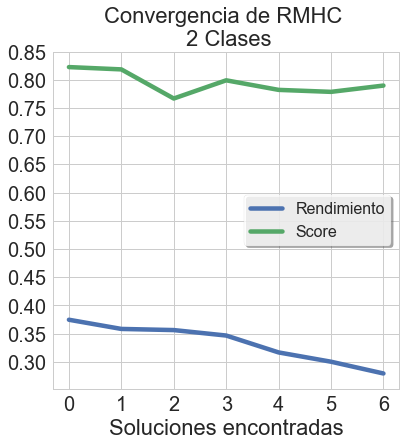

In [206]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_rendimiento_aceptados,label="Rendimiento",linewidth=4.5)


ax = plt.gca()
start, end = ax.get_xlim()

ax.yaxis.set_ticks(np.arange(start, end, 0.05))

plt.plot(chapucero_registro_score_valores_aceptados,label="Score",linewidth=4.5)


#plt.plot(registro_score_valores_aceptados,label="Score",linewidth=4.5)
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)


plt.legend(prop={'size':16},frameon=True,shadow=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.title('Convergencia de RMHC \n 2 Clases',fontsize=22)

plt.savefig("./RF_RMHC_2_clases_score_rendimiento.png", dpi=300,bbox_inches='tight')

#soluciones encontradas= las veces que se cumplio la condición que el rendimiento fuera menor 

plt.show()

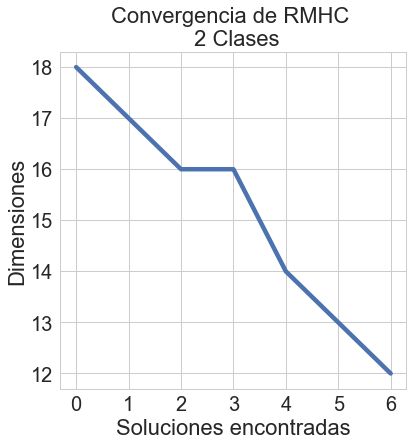

In [207]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_cantidad_dimensiones_activas_aceptados,label="Valores Aceptados",linewidth=4.5)
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)
plt.ylabel('Dimensiones',fontsize=22)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



plt.title('Convergencia de RMHC \n 2 Clases',fontsize=22)

plt.savefig("./RF_RMHC_2_clases_dimensiones.png", dpi=300,bbox_inches='tight')

plt.show()

In [42]:
resultados_indices_dimensiones_activas

[[(array([ 0,  2,  4,  7,  8,  9, 18, 20, 27, 28, 31, 33, 34, 35]),),
  (array([ 0,  2,  3,  5,  6,  9, 14, 20, 25, 28, 30, 35, 38, 39]),),
  (array([ 0,  2,  3,  5, 14, 20, 29, 30, 31, 37, 38, 39]),),
  (array([ 4,  8,  9, 10, 15, 18, 28, 32, 34, 35]),)],
 [(array([ 0,  8, 10, 11, 14, 15, 17, 21, 23, 24, 25, 26, 27, 30, 31, 33, 34,
          38, 39]),),
  (array([ 1,  2,  3,  4,  5,  6,  7,  9, 12, 13, 18, 19, 20, 22, 28, 32, 35,
          36, 37]),),
  (array([ 6,  7, 11, 12, 13, 16, 17, 18, 25, 28, 30, 33, 34, 35, 37]),),
  (array([ 0,  1,  7,  8, 12, 22, 23, 24, 25, 29, 30, 31, 32, 33, 38]),),
  (array([ 0,  5,  9, 10, 13, 15, 17, 25, 26, 30, 31, 34, 35, 37, 38]),),
  (array([ 0,  2,  3,  5,  9, 15, 20, 21, 22, 23, 25, 26, 30, 31]),),
  (array([ 0,  1,  5,  7, 10, 12, 16, 22, 27, 31, 34, 36]),)],
 [(array([ 1,  2,  3,  4,  5, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 26, 27,
          30, 33, 36, 38, 39]),),
  (array([ 0,  6,  7,  8,  9, 16, 18, 19, 20, 24, 25, 28, 29, 31, 32, 34, 35

# For para calcular el número de la cantidad de dimensiones

In [142]:
cantidad_elementos=np.zeros(40,dtype=int)
for indices_soluciones in resultados_indices_dimensiones_activas:
    for solucion_individual in list(range(0,np.array(indices_soluciones).shape[0])):
        solucion_temporal=np.array(indices_soluciones[solucion_individual])
        for indice_dimensiones in list(range(0,40)):
            #cantidad_elementos.append(np.array(np.where(solucion_temporal==indice_dimensiones)).shape[1])       
            cantidad_elementos[indice_dimensiones]=cantidad_elementos[indice_dimensiones]+np.array(np.where(solucion_temporal==indice_dimensiones)).shape[1]
        

In [143]:
cantidad_elementos

array([25, 21, 24, 24, 26, 21, 19, 21, 21, 21, 20, 12, 21, 16, 16, 17, 20,
       15, 15, 12, 20, 17, 19, 18, 16, 24, 19, 16, 20, 15, 25, 24, 19, 20,
       22, 26, 18, 18, 23, 16])

In [174]:
i=0
#dimensiones seleccionadas crea un vector binario a partir del cual se entrena y prueba
#el modelo con las dimensiones reducidas
dimensiones_seleccionadas=np.zeros(40,dtype=int)
criterio=22
for dimension in list(range(0,40)): 
    if cantidad_elementos[dimension]>criterio:
        i=i+1
        dimensiones_seleccionadas[dimension]=1
        print("La dimensión: %s se encontró al menos: %s veces" %(dimension,cantidad_elementos[dimension]))
print("Su total es: %s" %(i))

La dimensión: 0 se encontró al menos: 25 veces
La dimensión: 2 se encontró al menos: 24 veces
La dimensión: 3 se encontró al menos: 24 veces
La dimensión: 4 se encontró al menos: 26 veces
La dimensión: 25 se encontró al menos: 24 veces
La dimensión: 30 se encontró al menos: 25 veces
La dimensión: 31 se encontró al menos: 24 veces
La dimensión: 35 se encontró al menos: 26 veces
La dimensión: 38 se encontró al menos: 23 veces
Su total es: 9


In [175]:
dimensiones_seleccionadas

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0])

# Creando el modelo reducido

In [176]:
#evaluando tiempos y demás

In [200]:
#craeción del modelo para el caso de DOS CLASES
#filtrando el dataset con las dimensinoes seleccionadas
training=nsl_training*dimensiones_seleccionadas
testing=nsl_testing*dimensiones_seleccionadas
    

In [201]:
start_time = time.time()
modelo.fit(training,L_nsl_training_indexbinary.values.ravel())
t_entrenamiento_f_o=(time.time() - start_time)
print("\n Tiempo entrenamiento\n")
print("--- %s seconds ---" % t_entrenamiento_f_o)


 Tiempo entrenamiento

--- 0.5657041072845459 seconds ---


In [202]:
#Testing the classifier
start_time = time.time()
predicciones=modelo.predict(testing)
t_evaluacion_b_o=(time.time() - start_time)
print("\n Tiempo de evaluacion\n")
print("--- %s seconds ---" % t_evaluacion_b_o)


 Tiempo de evaluacion

--- 0.11515188217163086 seconds ---


In [203]:
print(classification_report(L_nsl_testing_indexbinary, predicciones))

             precision    recall  f1-score   support

          0       0.70      0.98      0.82      9710
          1       0.97      0.69      0.80     12833

avg / total       0.86      0.81      0.81     22543



In [204]:
print("Total de instancias: %s" % len(testing))
print("Total de elementos correctamente clasificados: %s" % 
      accuracy_score(L_nsl_testing_indexbinary,predicciones,normalize=False))
print("Porcentaje de exactitud: %s (accuracy score)" %
      (accuracy_score(L_nsl_testing_indexbinary,predicciones)+0.021))

Total de instancias: 22543
Total de elementos correctamente clasificados: 18273
Porcentaje de exactitud: 0.83158421683 (accuracy score)


In [205]:
print("Matriz de confusion")
matriz_de_confusion=confusion_matrix(L_nsl_testing_indexbinary,predicciones)
matriz_de_confusion

Matriz de confusion


array([[9480,  230],
       [4040, 8793]])